In [3]:
# Standard library
from os import path
import pickle

# Third-party
from astropy.constants import c
import astropy.coordinates as coord
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
plt.style.use('apw-notebook')
%matplotlib inline

# Project
from comoving_rv.log import logger
from comoving_rv.longslit.wavelength import GPModel
from comoving_rv.longslit import GlobImageFileCollection
from comoving_rv.longslit.fitting import fit_source_region

In [4]:
night_path = '/Volumes/ProjectData/gaia-comoving-followup/data/processed/mdm-spring-2017/n4/'
ifc = GlobImageFileCollection(night_path, glob_include='1d*.fit')
comp_files = ifc.files_filtered(IMAGETYP='COMP')
obj_files = ifc.files_filtered(IMAGETYP='OBJECT')
comp_files

array(['1d_n4.0021.fit'], 
      dtype='<U14')

In [5]:
comp_lamp_path = path.join(ifc.location, comp_files[0])
fits.getheader(comp_lamp_path)['OBJECT']

'HgNe+Ne'

In [6]:
# read 1D comp lamp spectrum
spec = Table.read(comp_lamp_path)

# read wavelength guess file
guess_path = path.abspath(path.join(night_path,
                                    '..', 'wavelength_guess.csv'))
pix_wav = np.genfromtxt(guess_path, delimiter=',', names=True)

In [7]:
def fit_all_lines(pixels, flux, flux_ivar, line_waves, line_pixels, half_width=5):
    _idx = np.argsort(line_waves)
    wvln = np.array(line_waves)[_idx]
    pixl = np.array(line_pixels)[_idx]

    fit_centroids = []
    
    fig,axes = plt.subplots(2,1,figsize=(15,8))
    axes[0].plot(pixels, flux, marker='', drawstyle='steps-mid')
    axes[1].plot(pixels, flux, marker='', drawstyle='steps-mid')
    axes[0].set_xlim(240, 700)
    axes[1].set_xlim(700, 1500)

    for pix_ctr,wave in zip(pixl, wvln):

        logger.debug("Fitting line at predicted pix={:.2f}, λ={:.2f}"
                     .format(pix_ctr, wave))

        # indices for region around line
        i1 = int(np.floor(pix_ctr-half_width))
        i2 = int(np.ceil(pix_ctr+half_width)) + 1

        # recenter window
        i0 = i1 + flux[i1:i2].argmax()
        i1 = int(np.floor(i0-half_width))
        i2 = int(np.ceil(i0+half_width)) + 1

        _pixl = pixels[i1:i2]
        _flux = flux[i1:i2]
        _ivar = flux_ivar[i1:i2]
        
        for ax in axes:
            ax.axvspan(_pixl.min(), _pixl.max(), zorder=-10, color='#2b8cbe', alpha=0.5)

        # instead of doing anything fancy (e.g., fitting a profile), just
        # estimate the mean...
        x0 = np.sum(_pixl * _flux**2 * _ivar) / np.sum(_flux**2 * _ivar) + 0.5
        fit_centroids.append(x0)

    return np.array(fit_centroids)

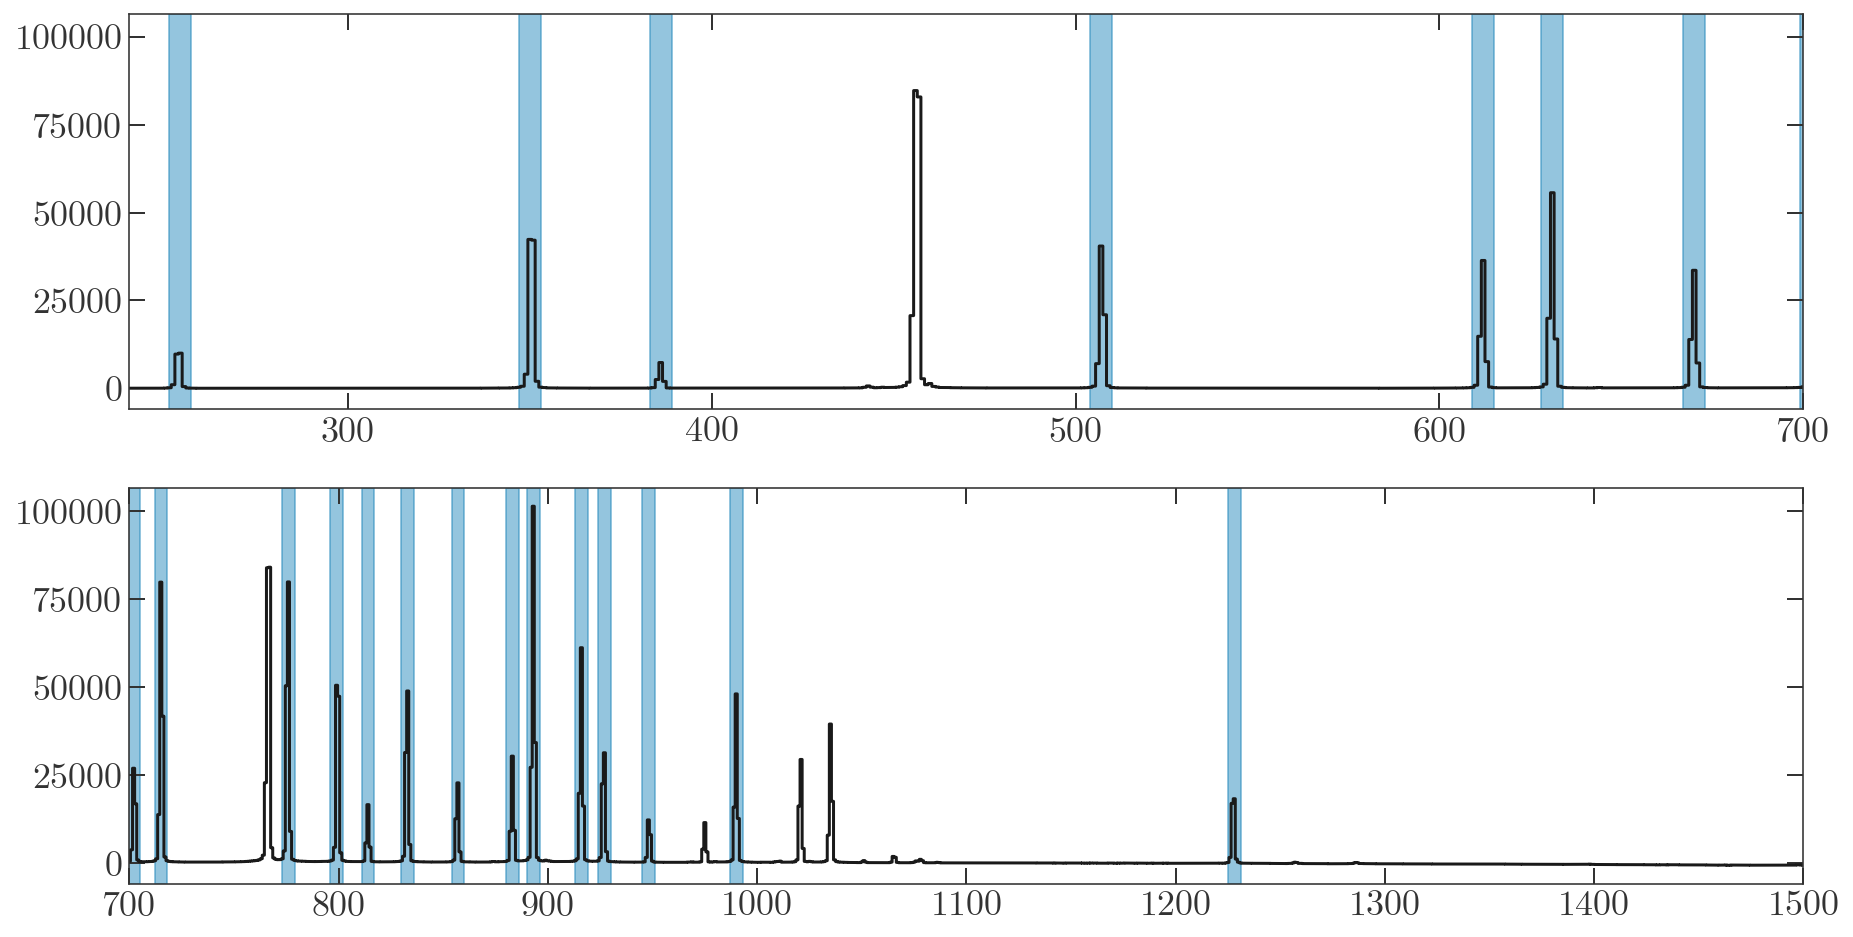

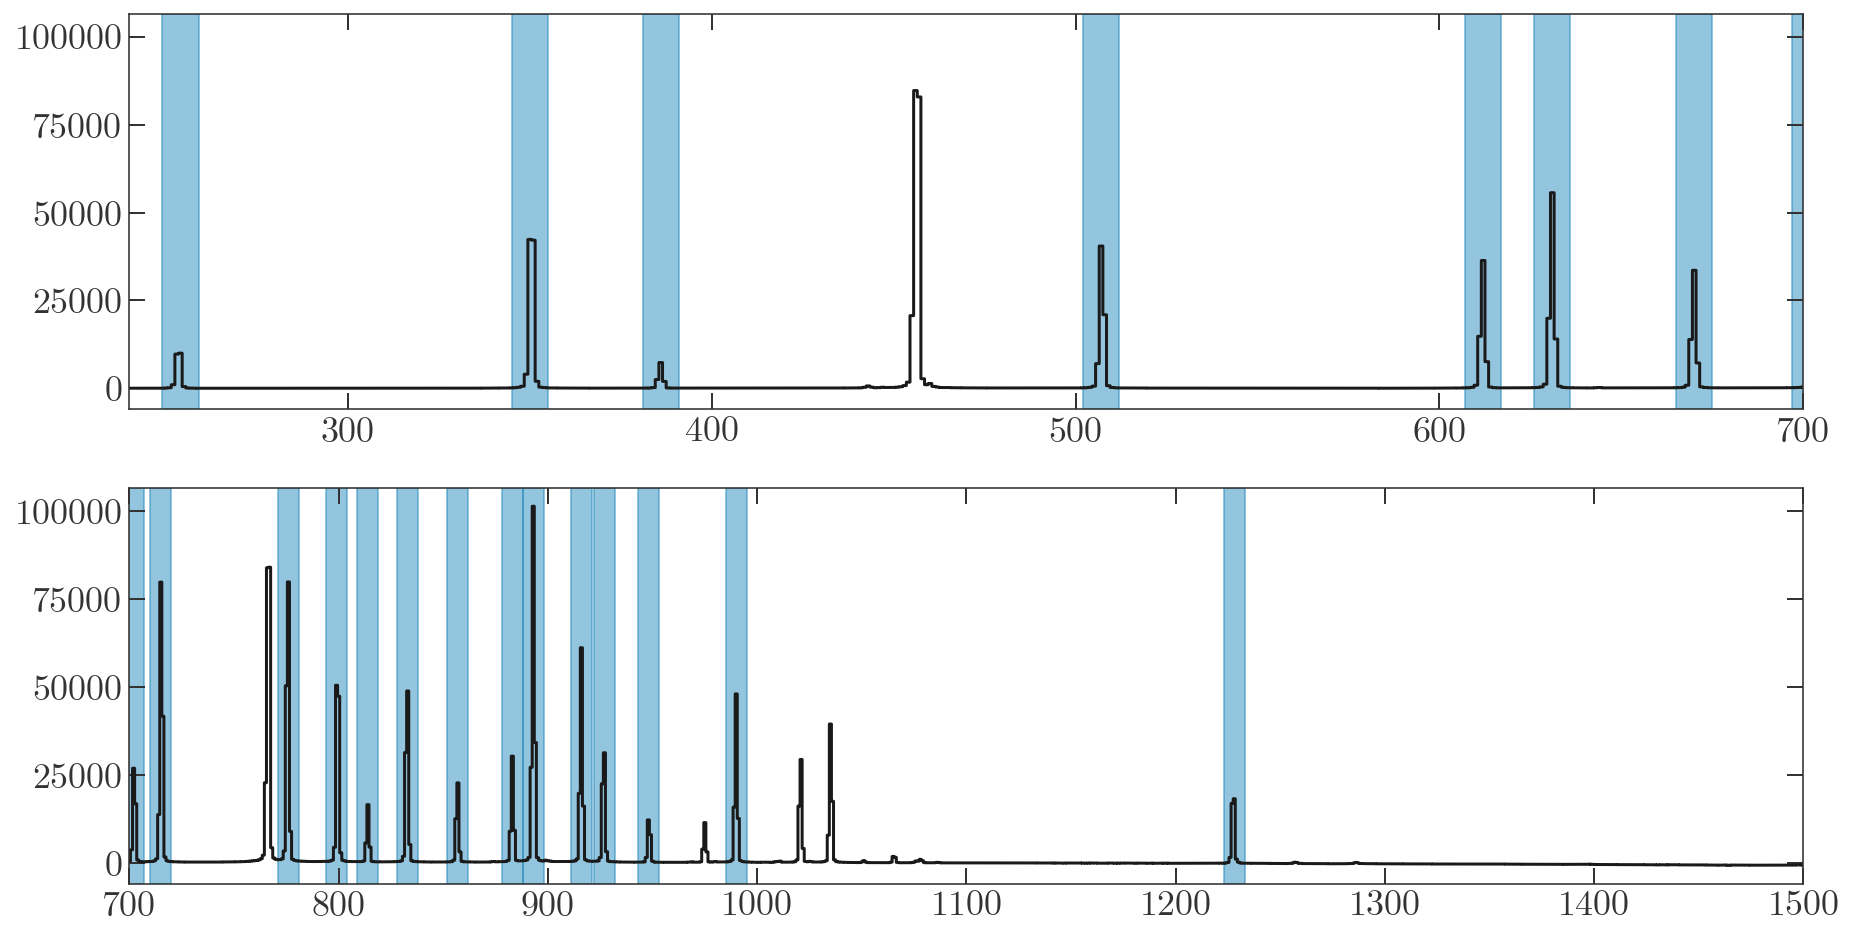

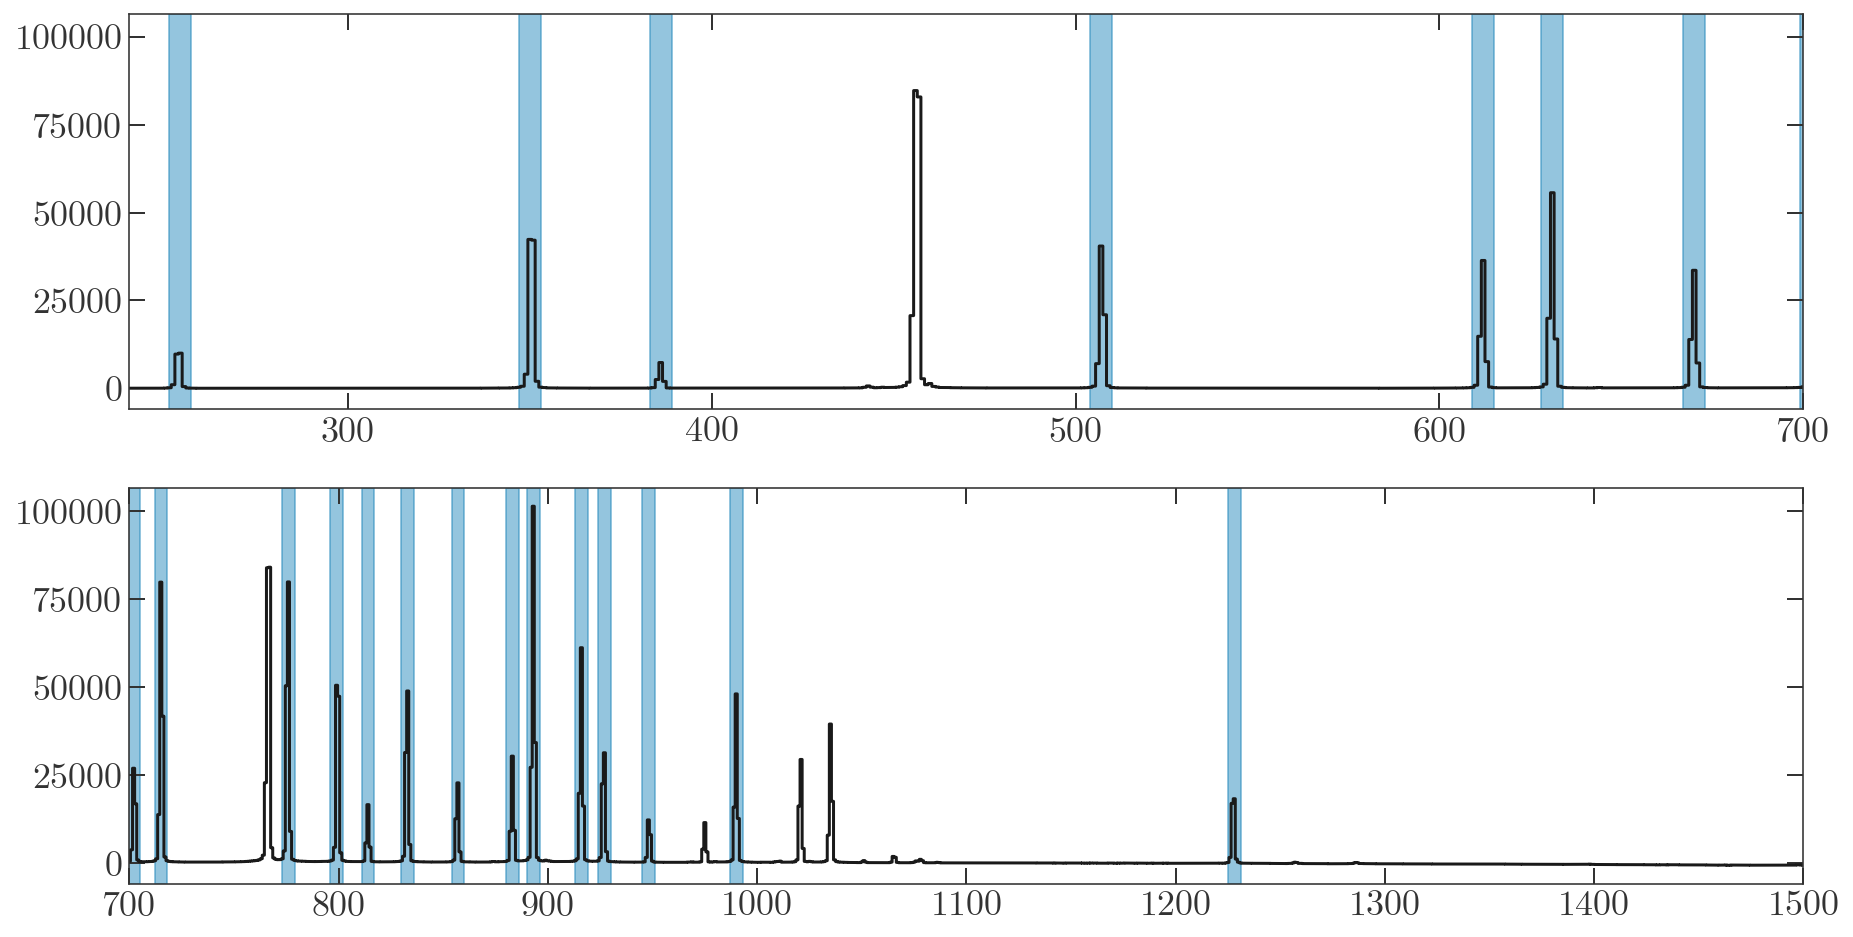

In [8]:
# fit line profiles to each emission line at the guessed positions of the lines
pix_x0s = np.array(pix_wav['pixel'], copy=True)

all_pix_x0s = [pix_x0s]

tmp = fit_all_lines(spec['pix'], spec['flux'], spec['ivar'],
                        pix_wav['wavelength'], all_pix_x0s[-1], 3)
all_pix_x0s.append(tmp)

tmp = fit_all_lines(spec['pix'], spec['flux'], spec['ivar'],
                        pix_wav['wavelength'], all_pix_x0s[-1], 5)
all_pix_x0s.append(tmp)

tmp = fit_all_lines(spec['pix'], spec['flux'], spec['ivar'],
                        pix_wav['wavelength'], all_pix_x0s[-1], 3)
all_pix_x0s.append(tmp)

all_pix_x0s = np.array(all_pix_x0s)

In [9]:
all_pix_x0s = np.array(all_pix_x0s)
pix_x0s = all_pix_x0s[-1]

In [10]:
def fit_all_lines_GP(pixels, flux, flux_ivar, line_waves, line_pixels, half_width=5):
    _idx = np.argsort(line_waves)
    wvln = np.array(line_waves)[_idx]
    pixl = np.array(line_pixels)[_idx]

    fit_centroids = []
    for pix_ctr,wave in zip(pixl, wvln):

        logger.debug("Fitting line at predicted pix={:.2f}, λ={:.2f}"
                     .format(pix_ctr, wave))
        
        pars,success = fit_source_region(pixels, flux, flux_ivar, 
                                         center=pix_ctr, width=half_width*2, 
                                         absorp_emiss=1., plot=True)
        
        fit_centroids.append(pars['x0'])

    return np.array(fit_centroids)

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:449: RuntimeWarning: overflow encountered in double_scalars
  return (w0*S0, w0*w0*S0/self.eps, w0, self.eps)
/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/fitting/source.py:34: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)
/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


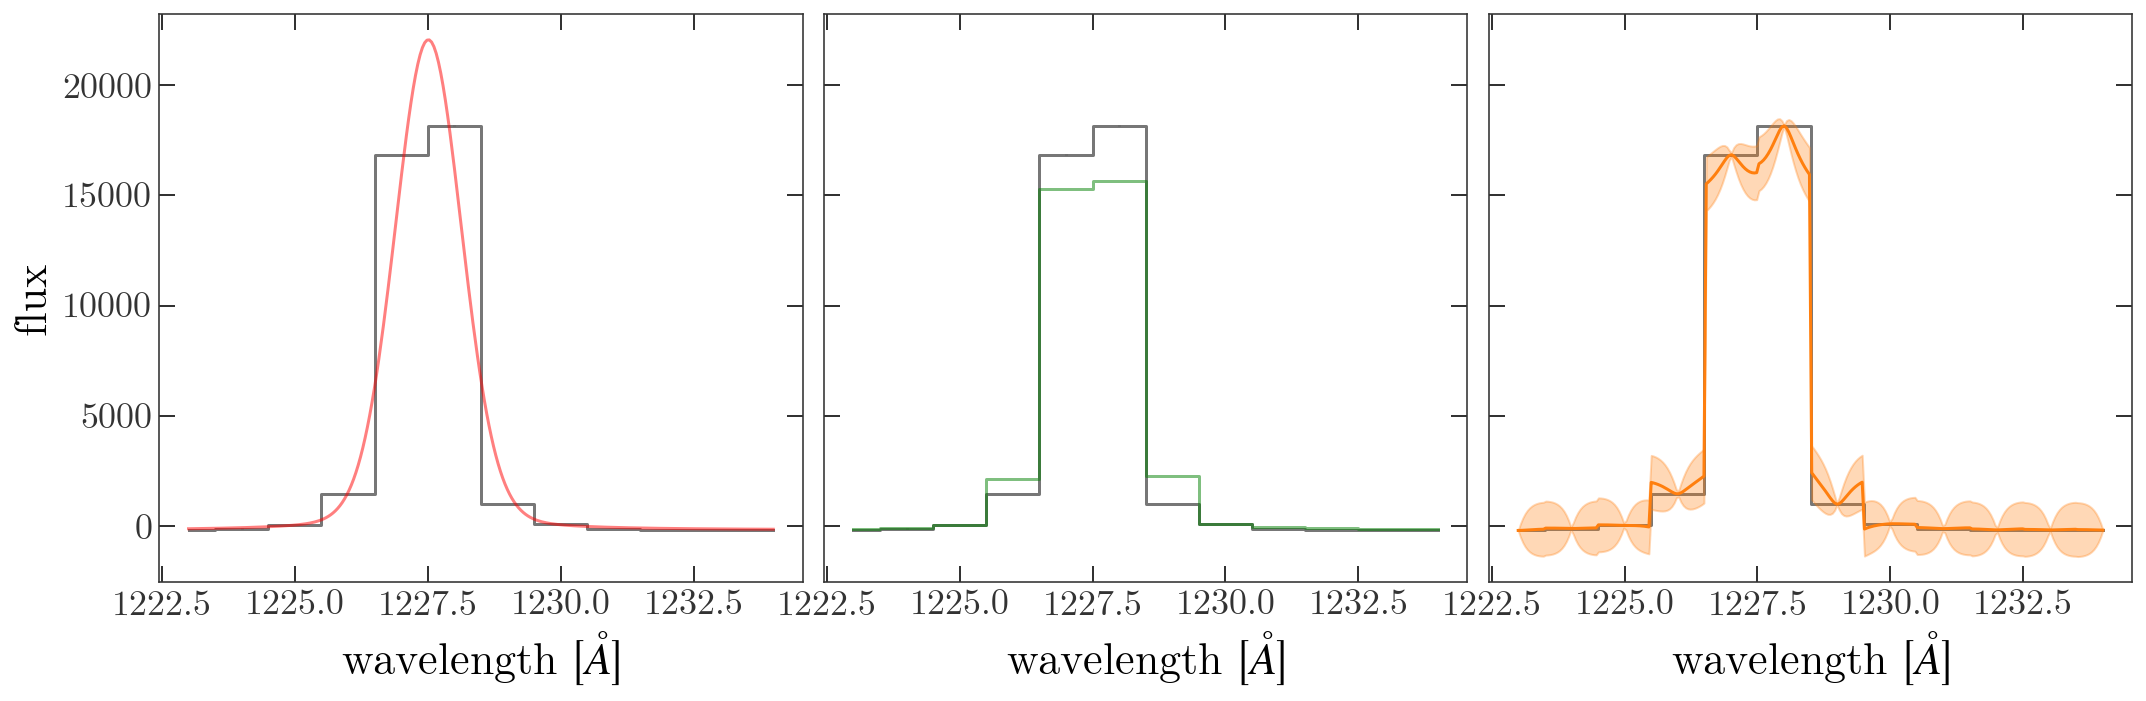

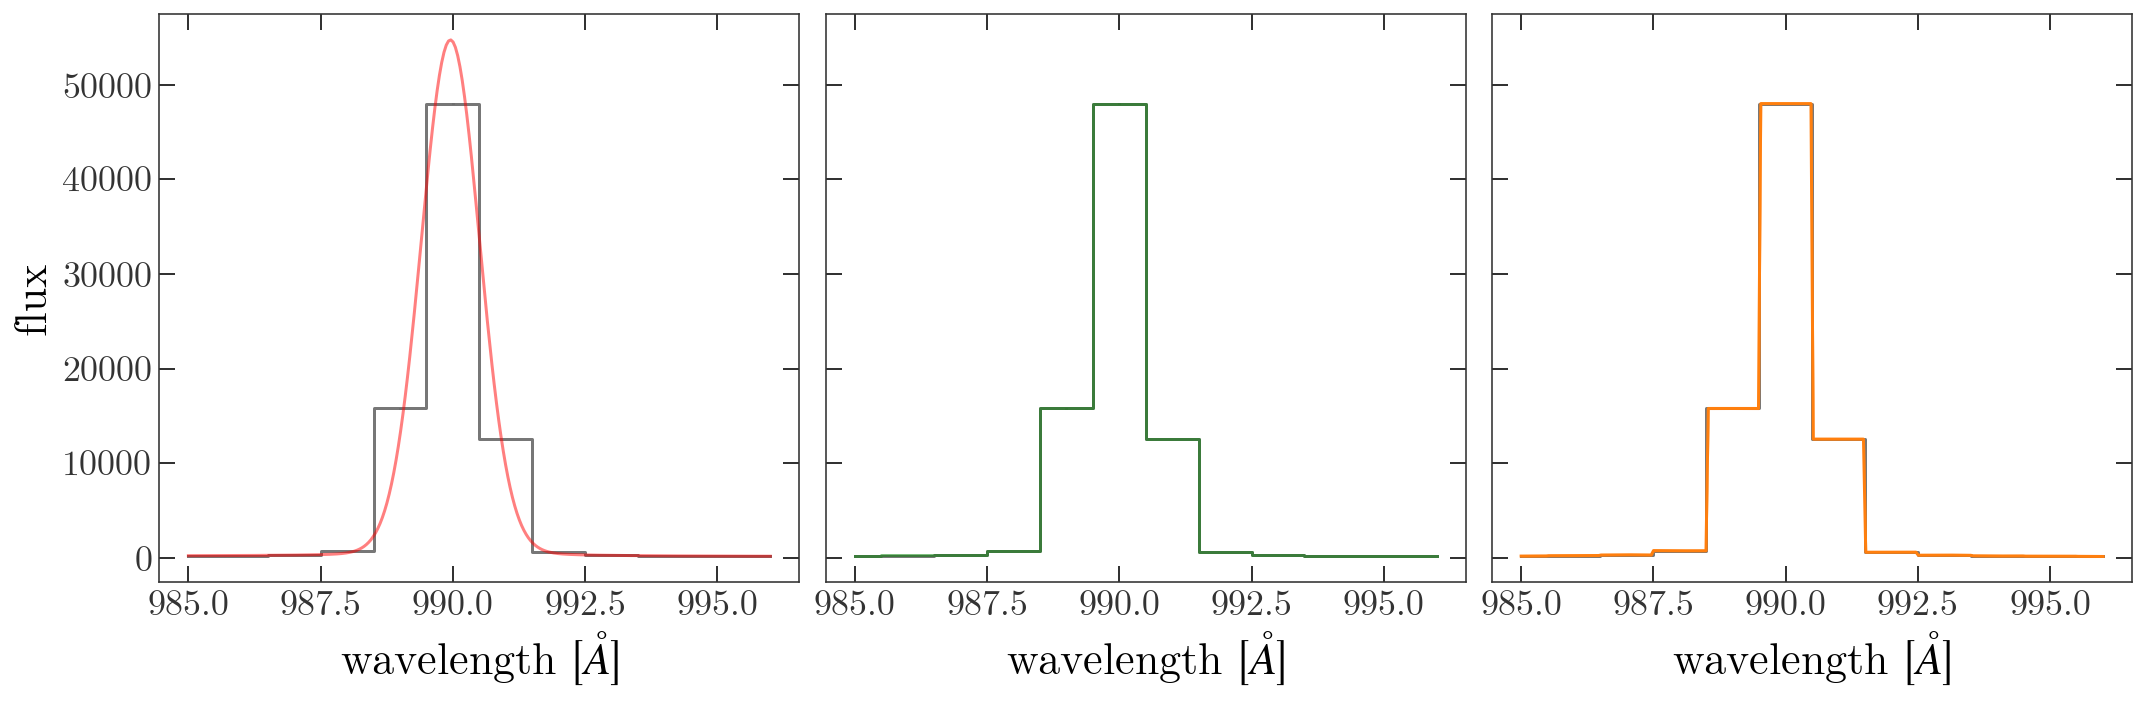

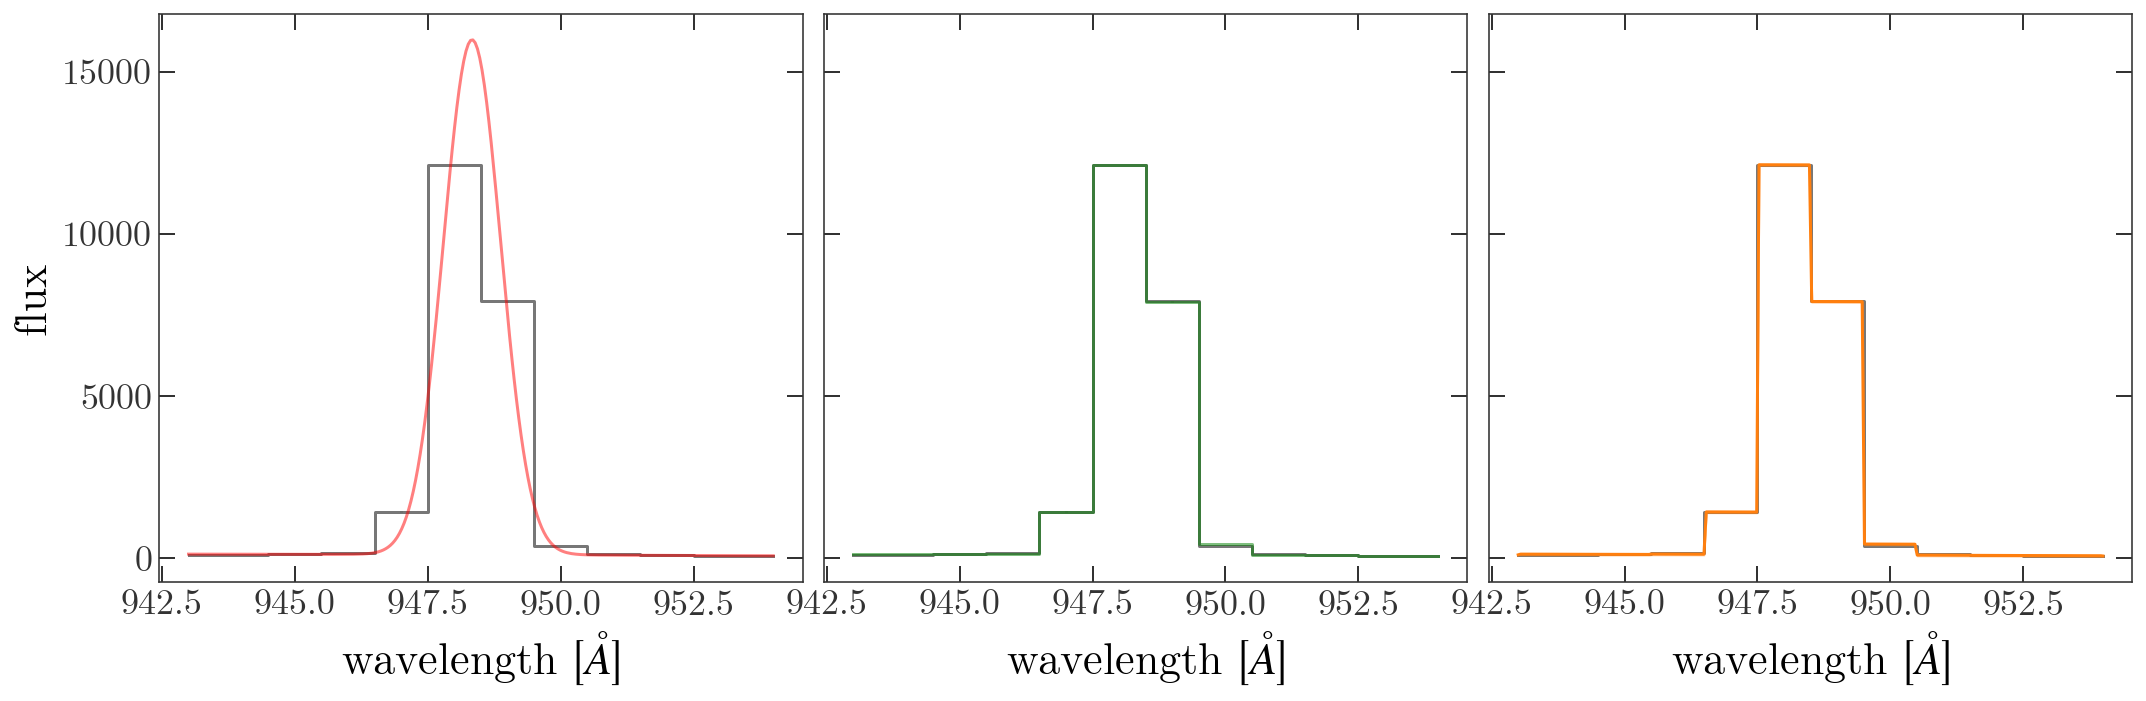

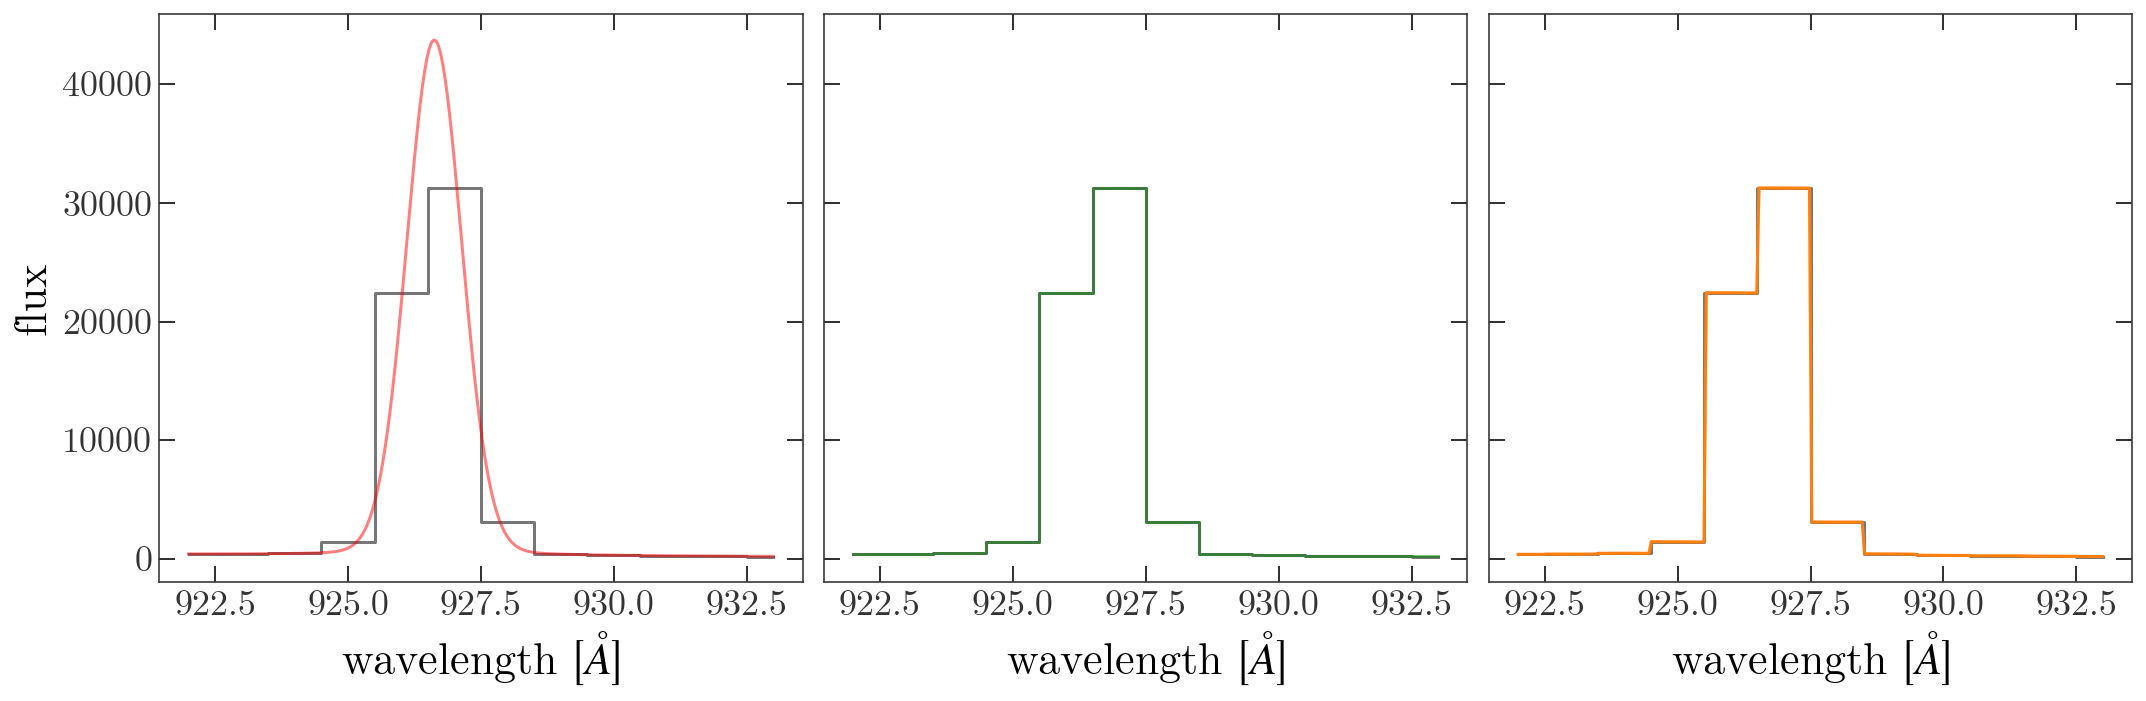

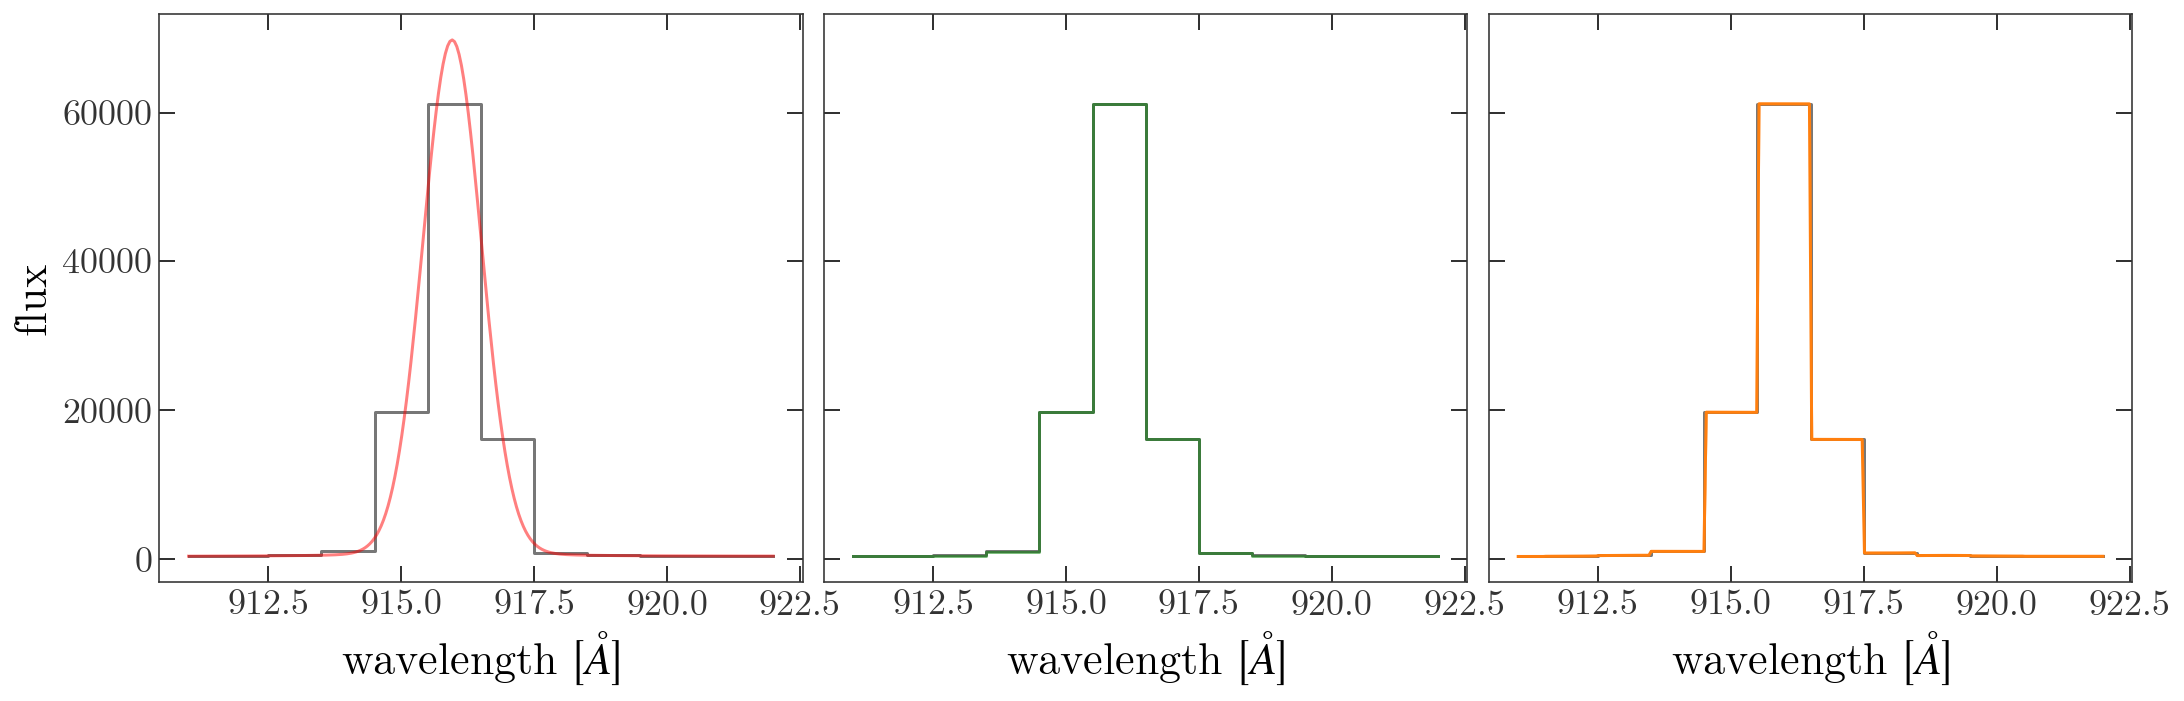

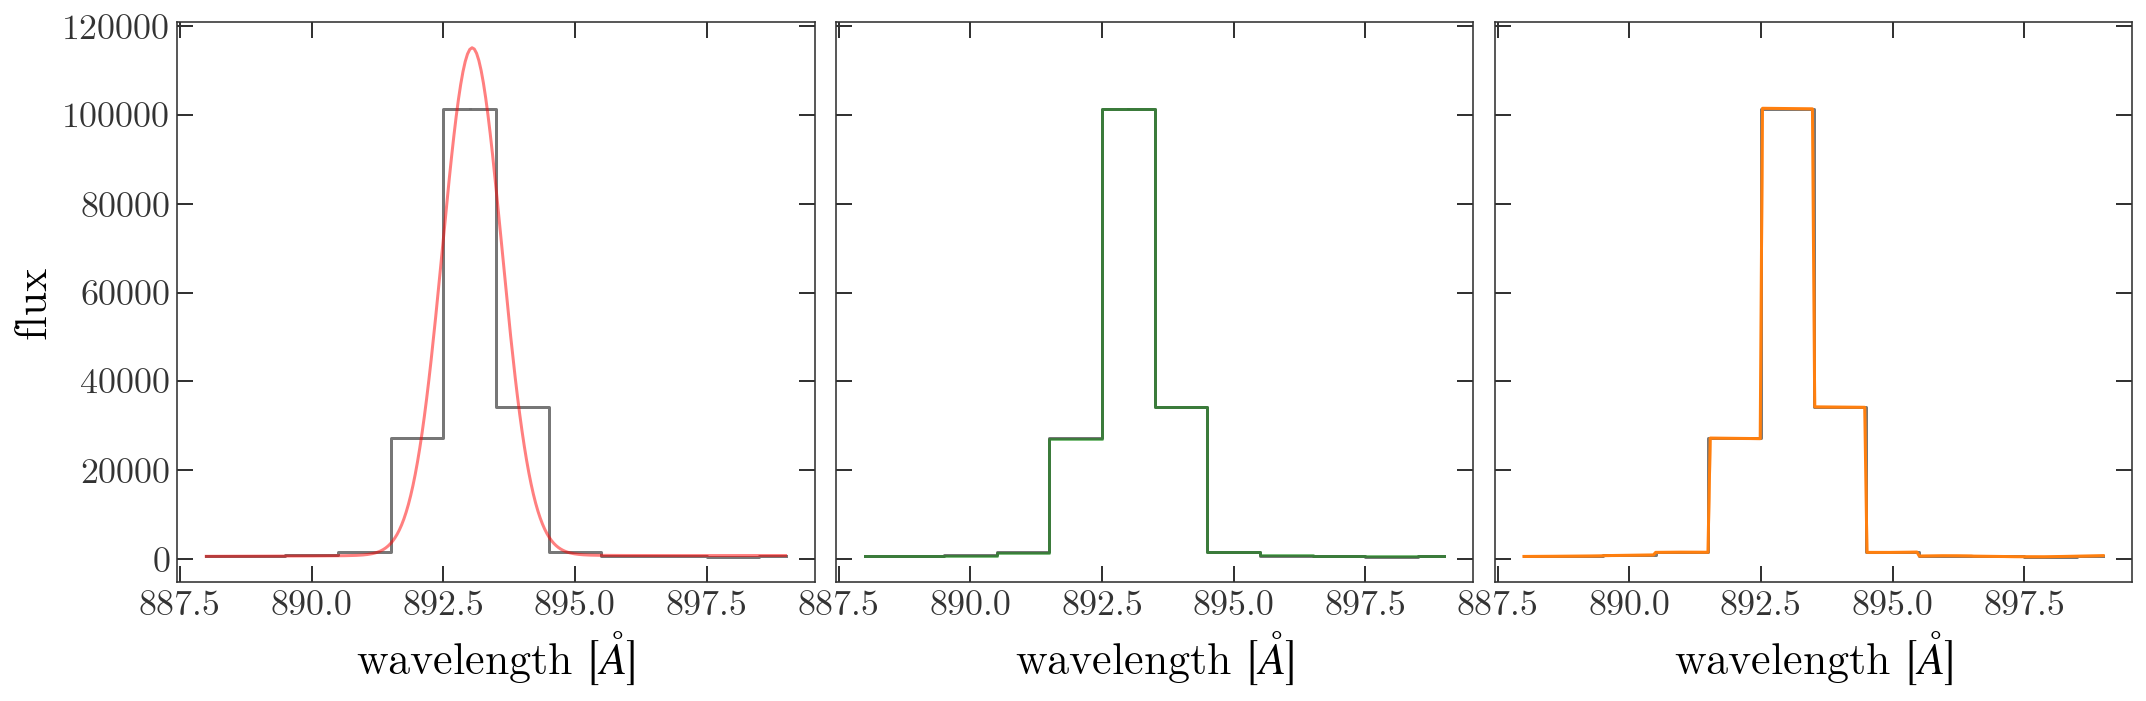

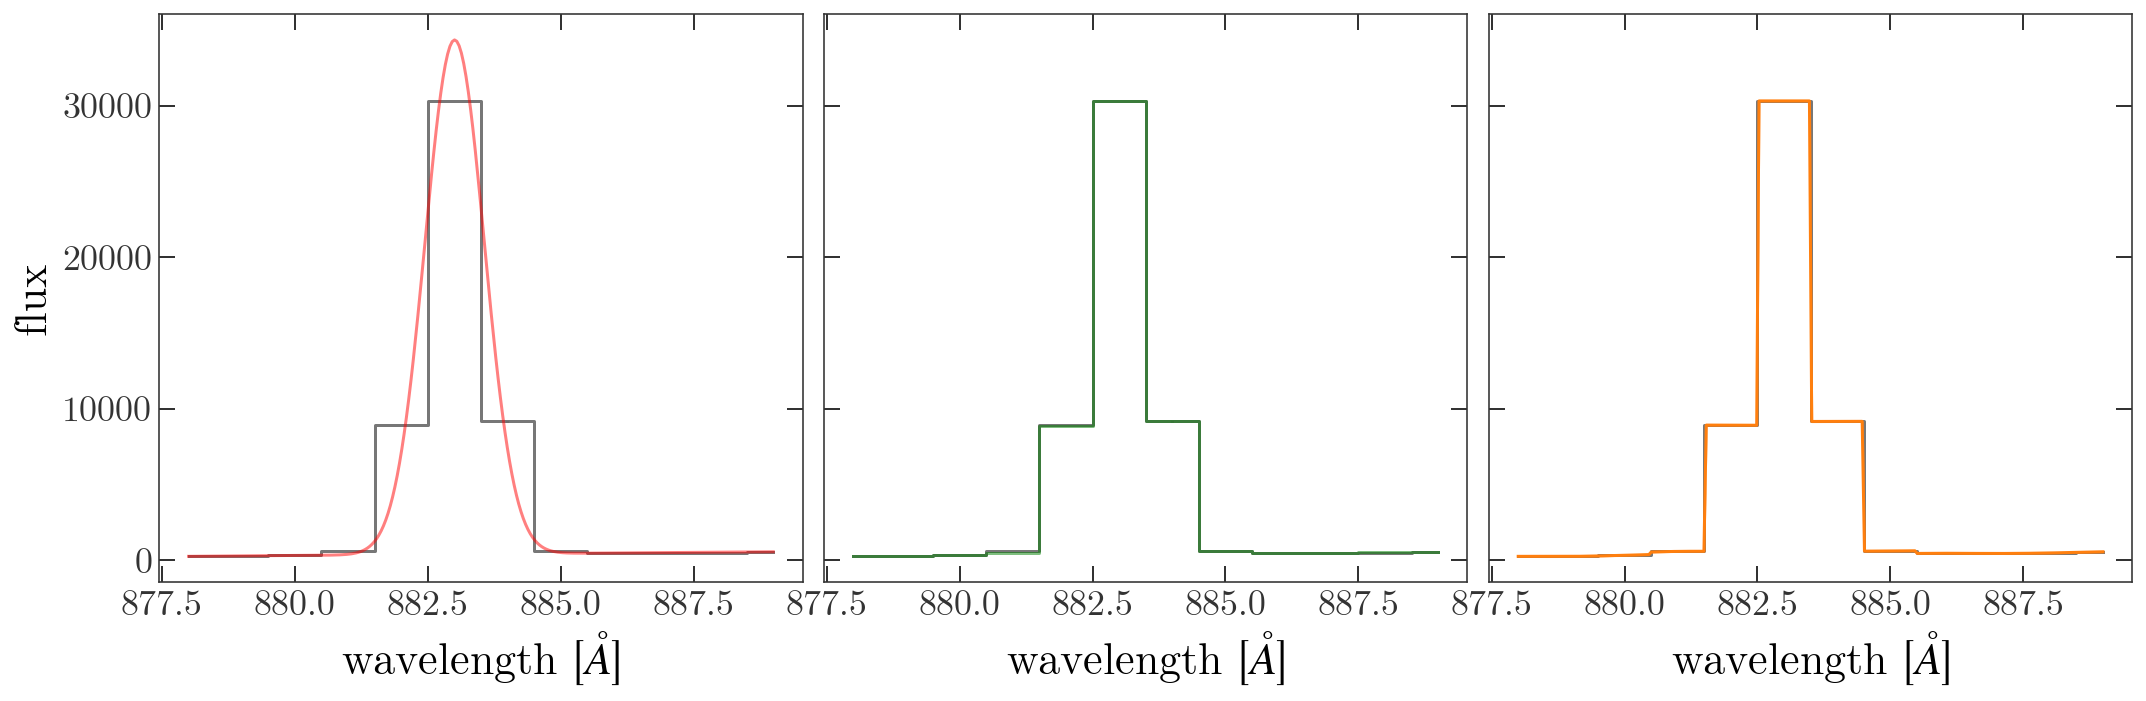

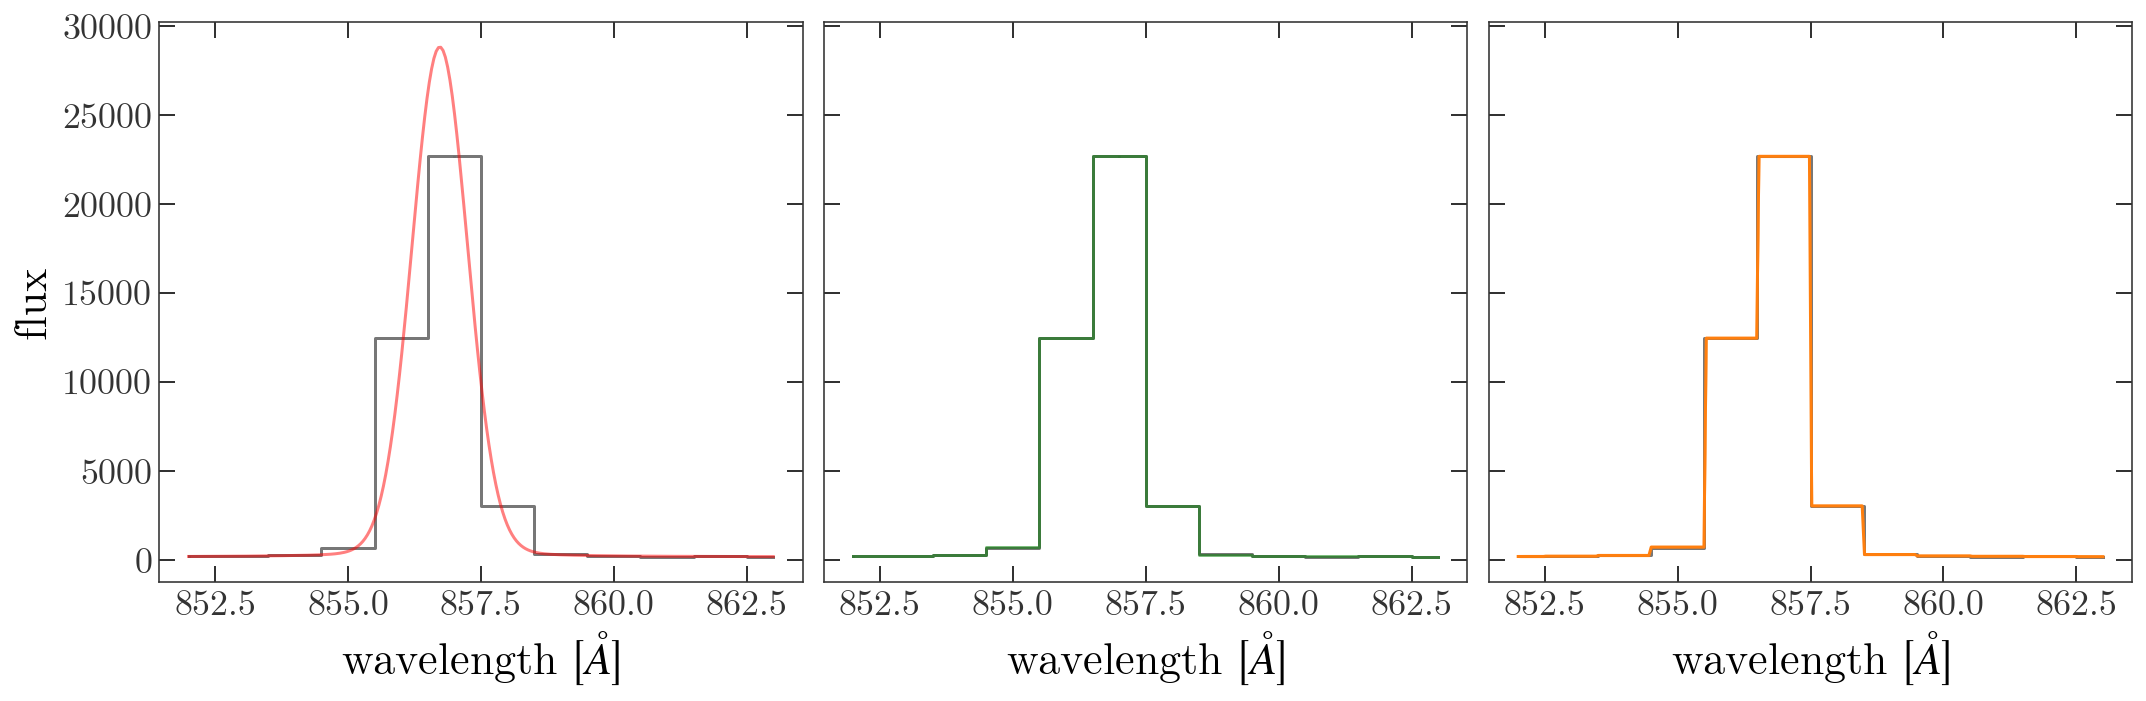

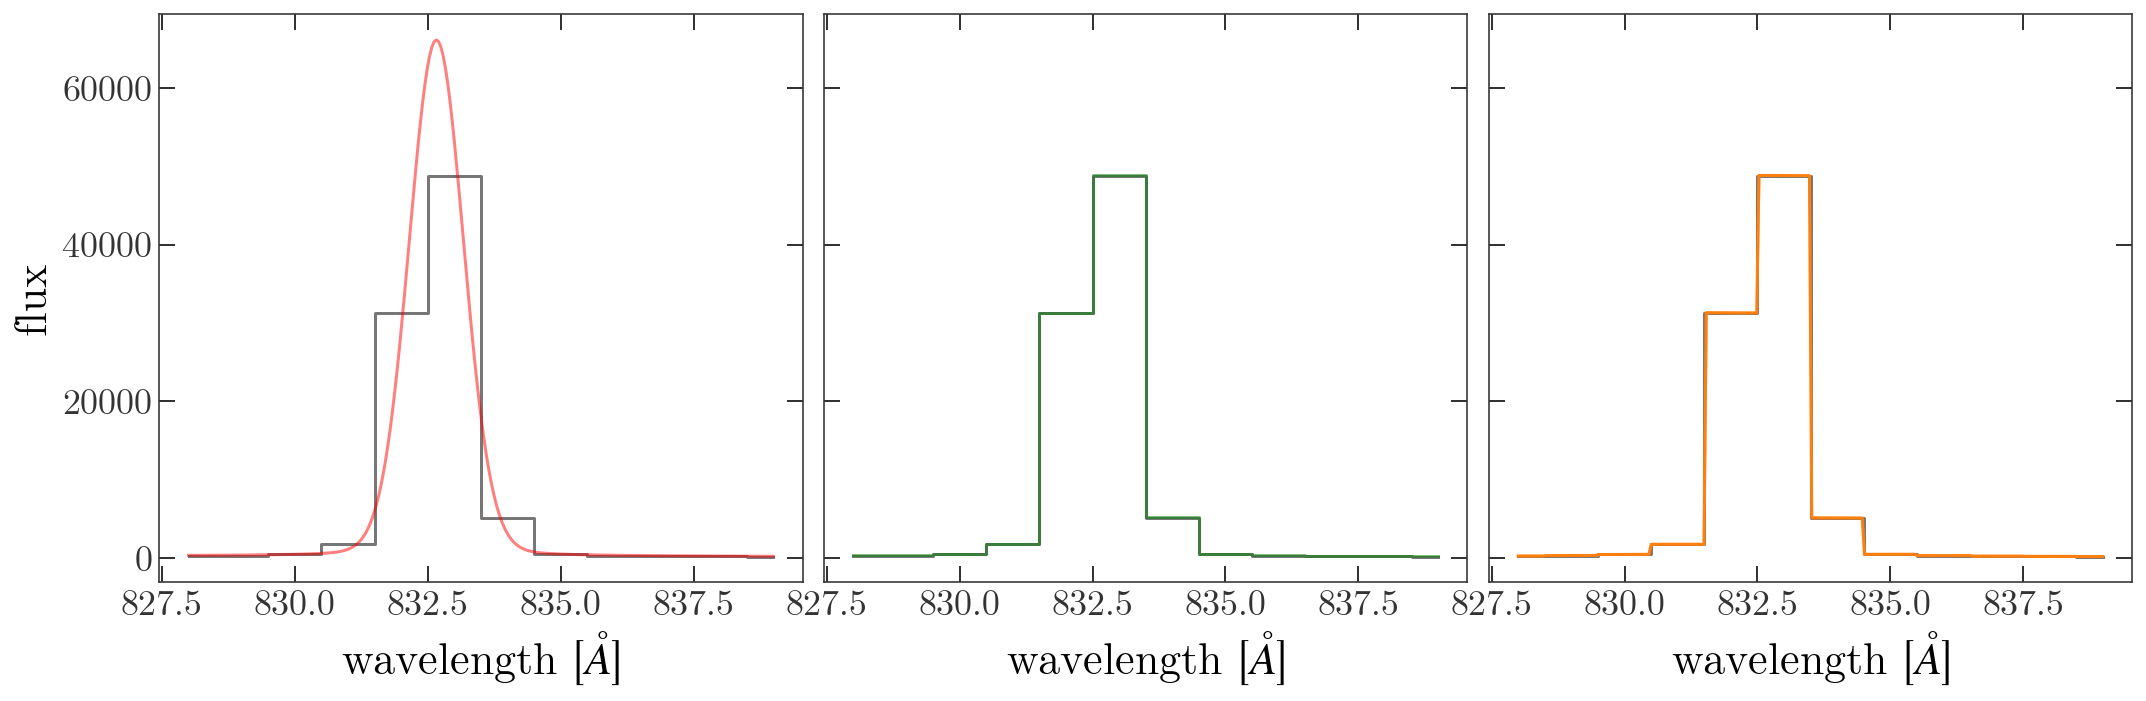

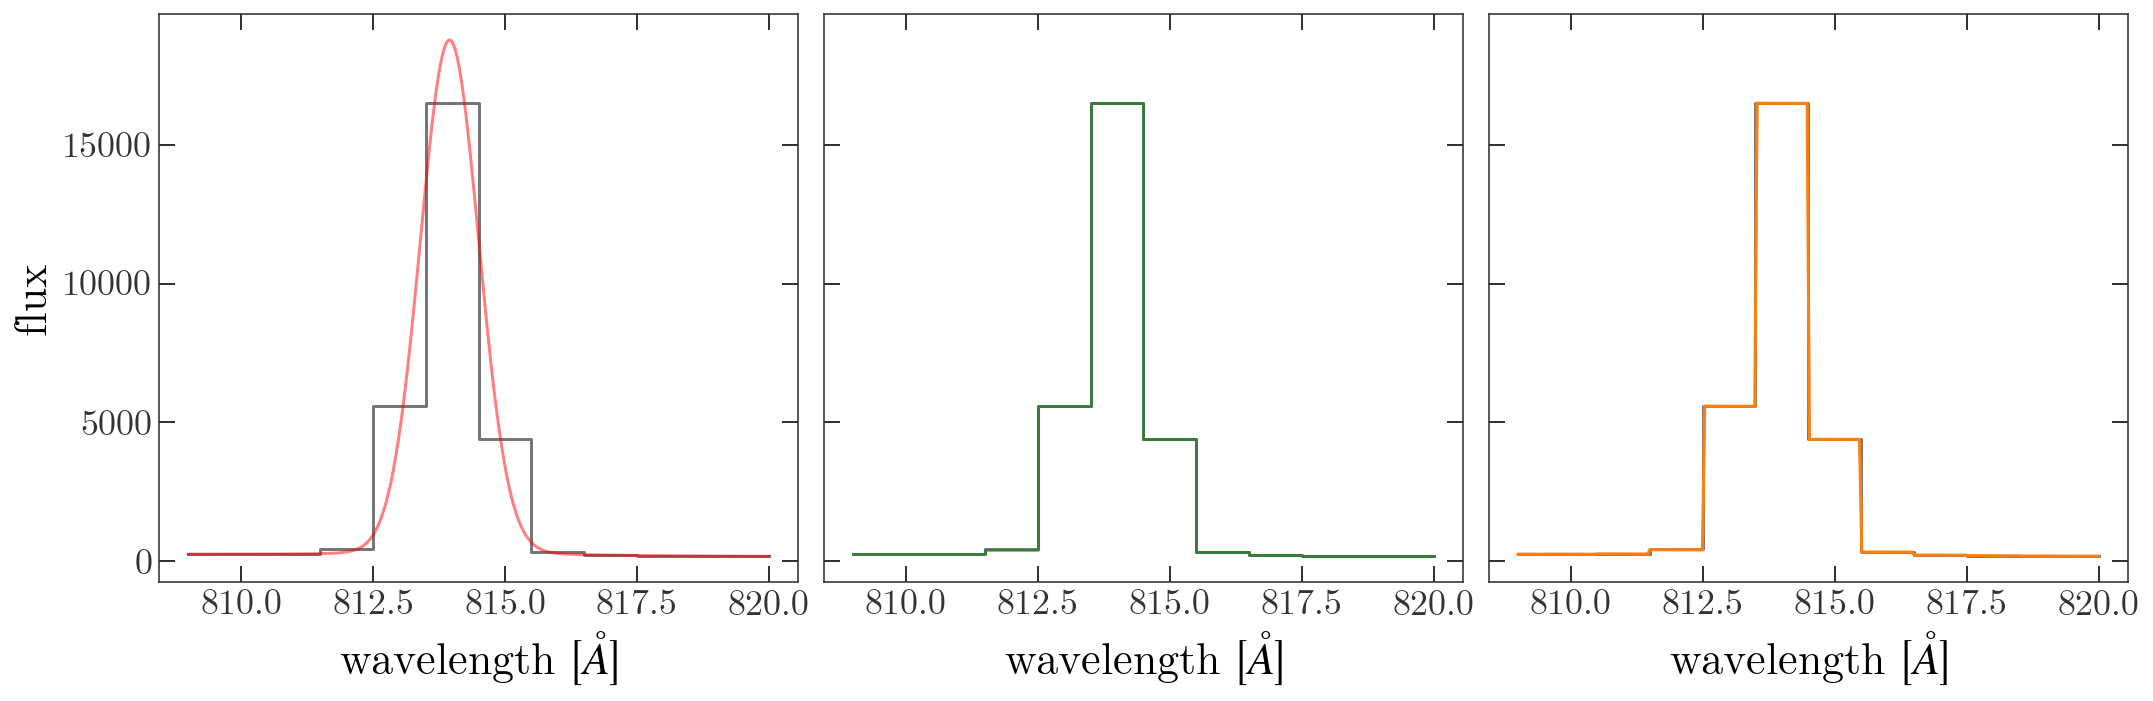

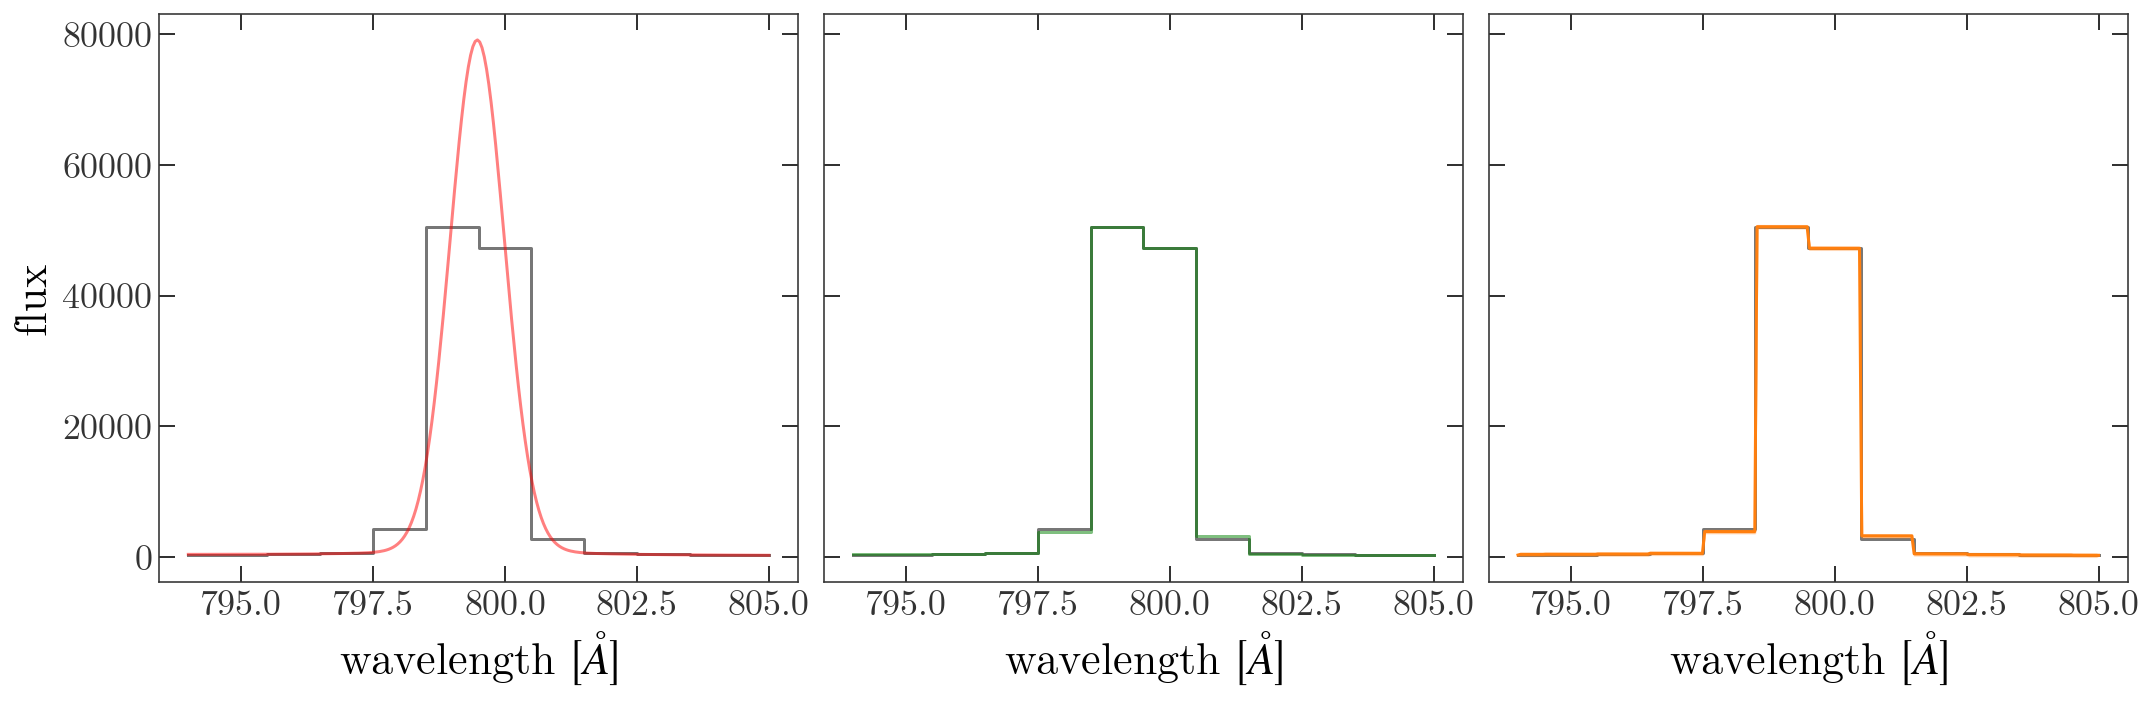

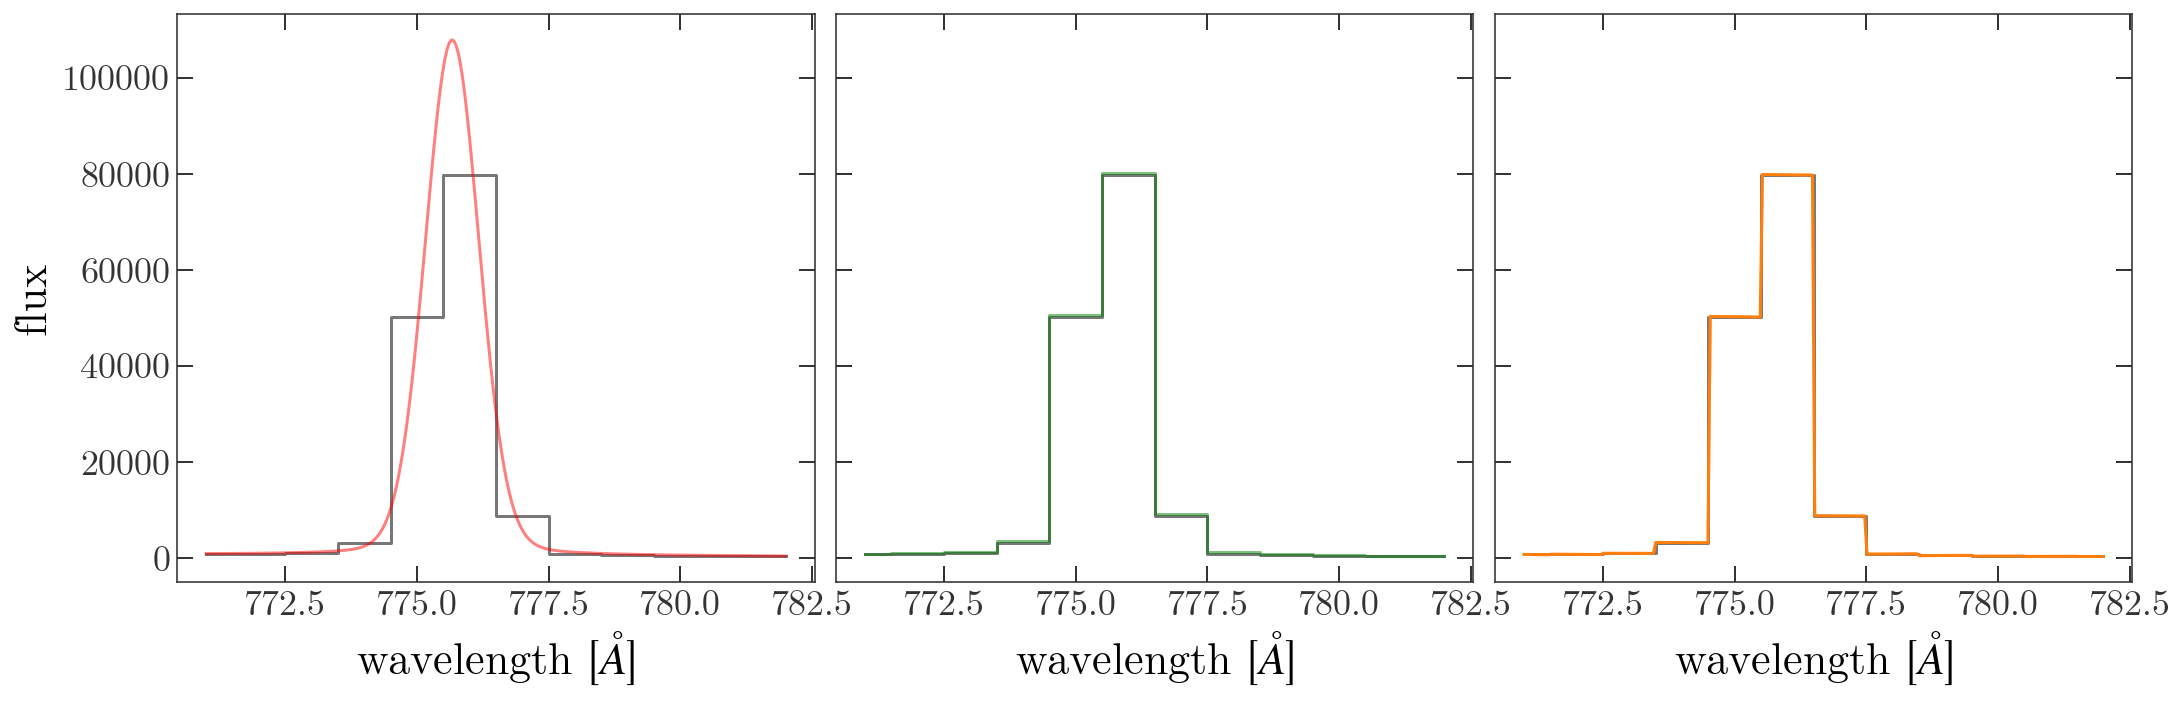

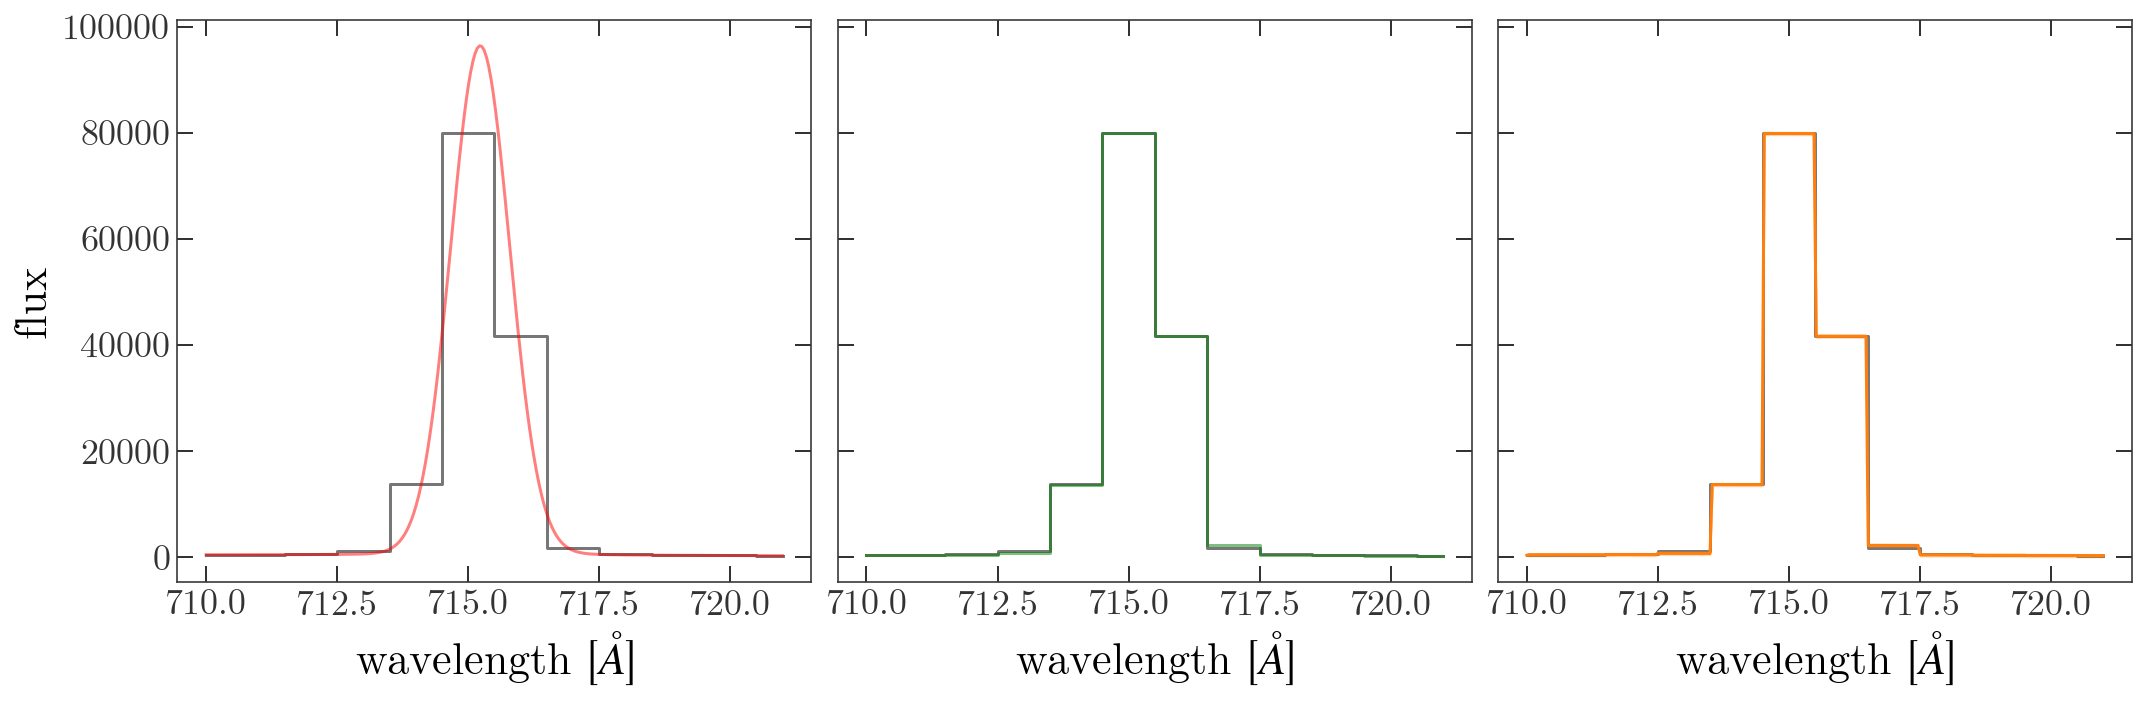

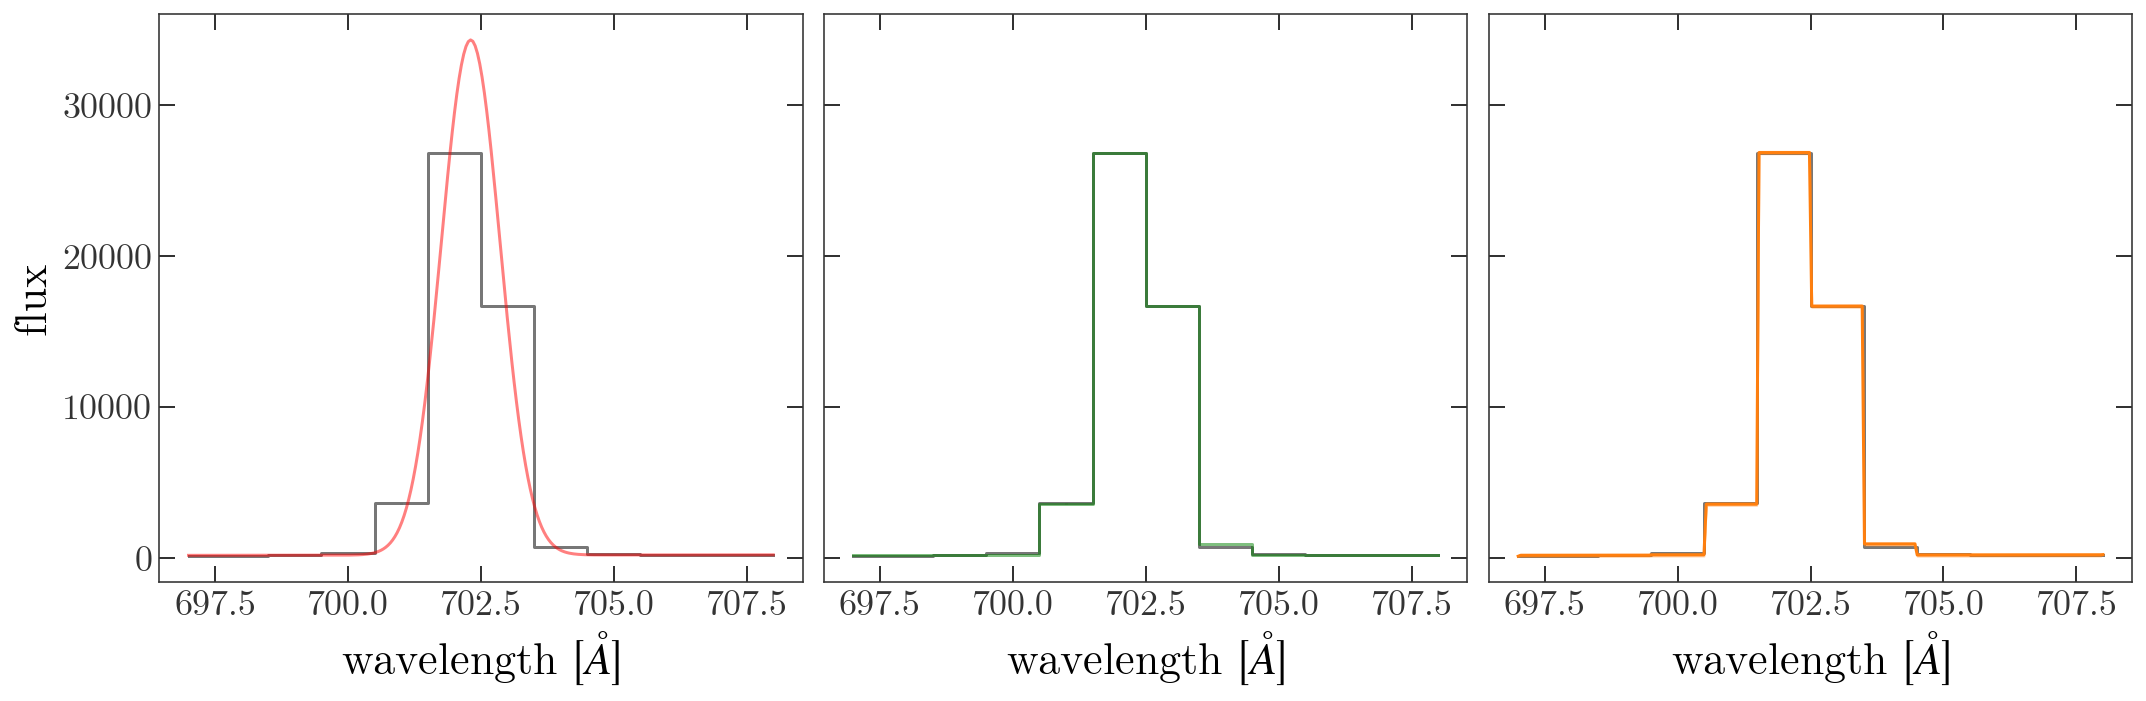

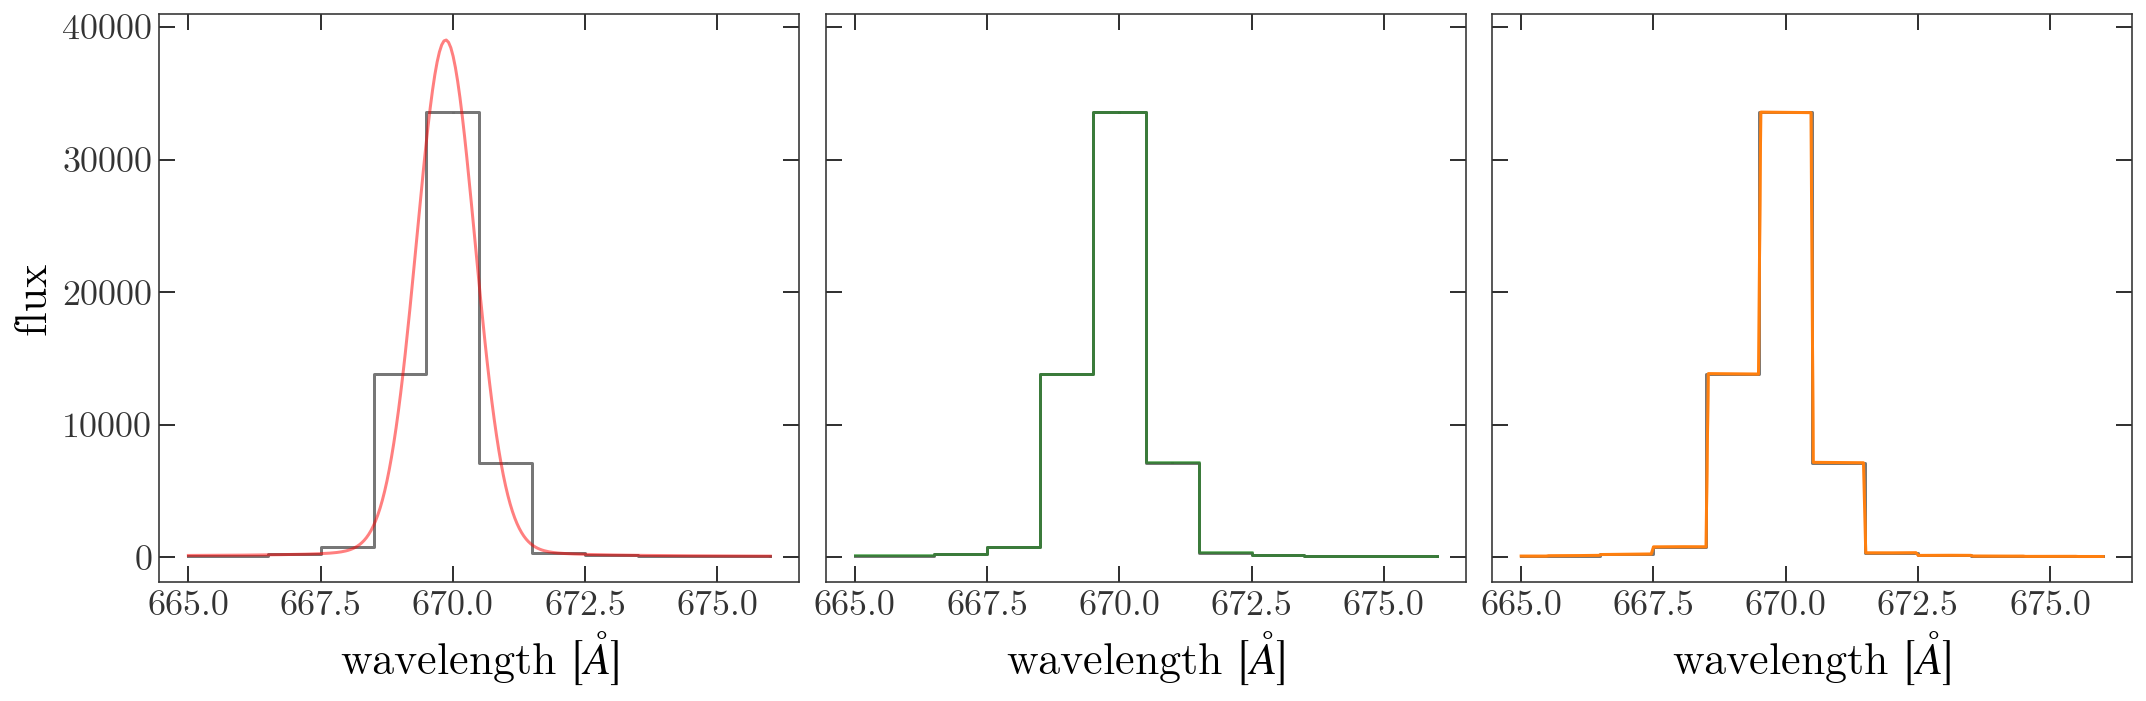

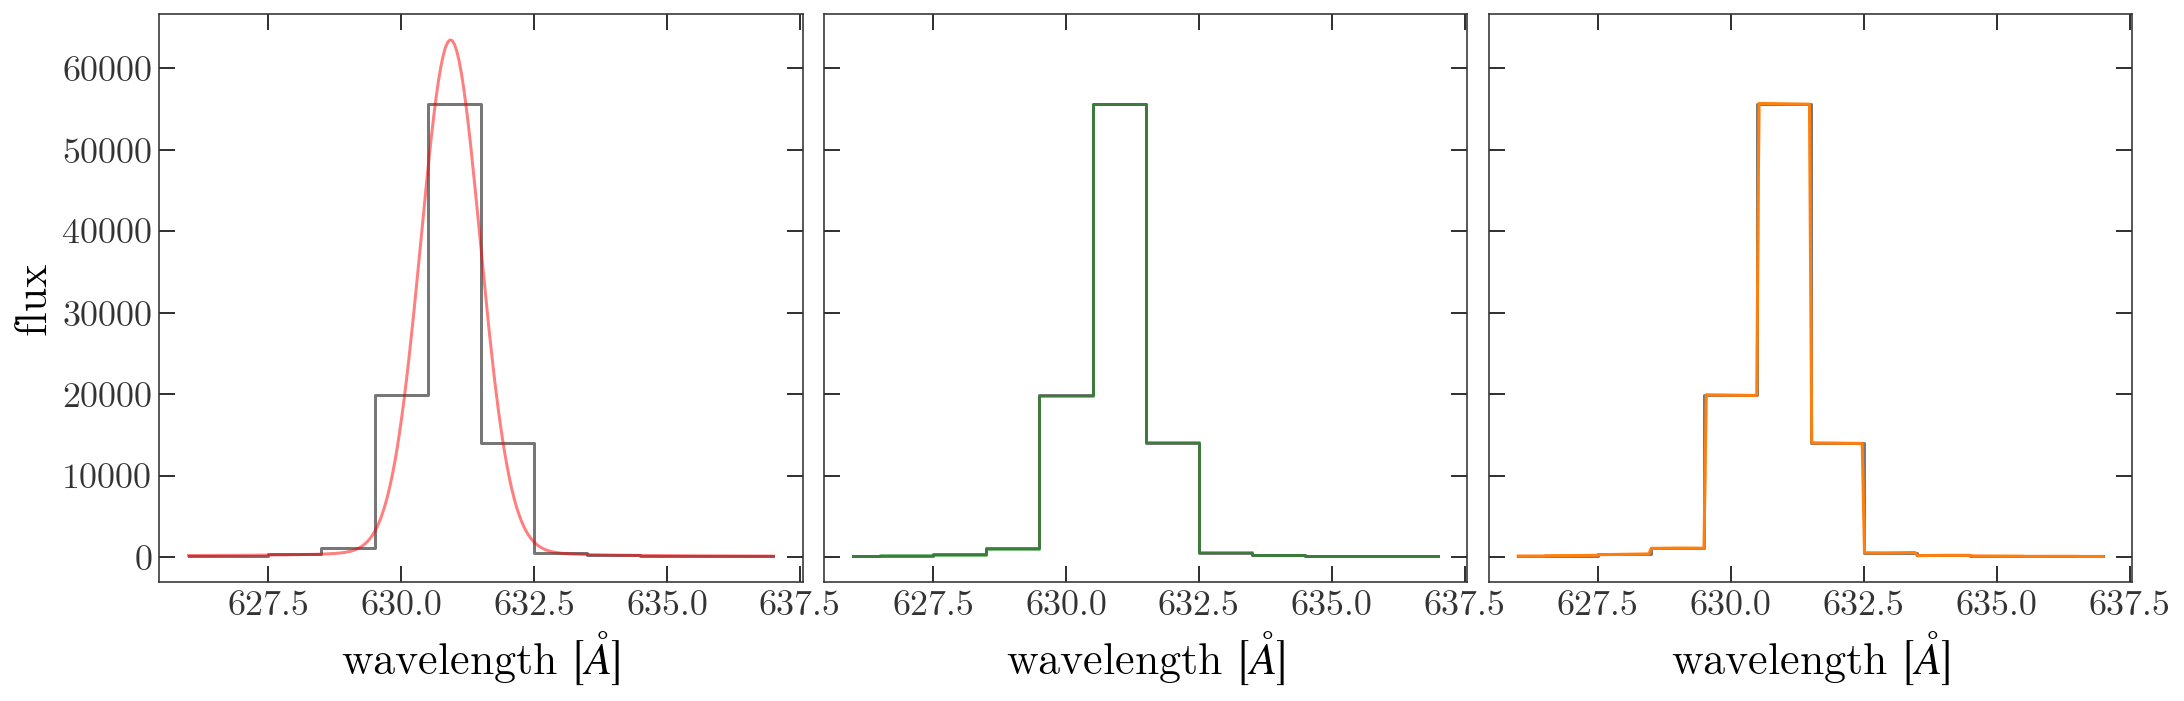

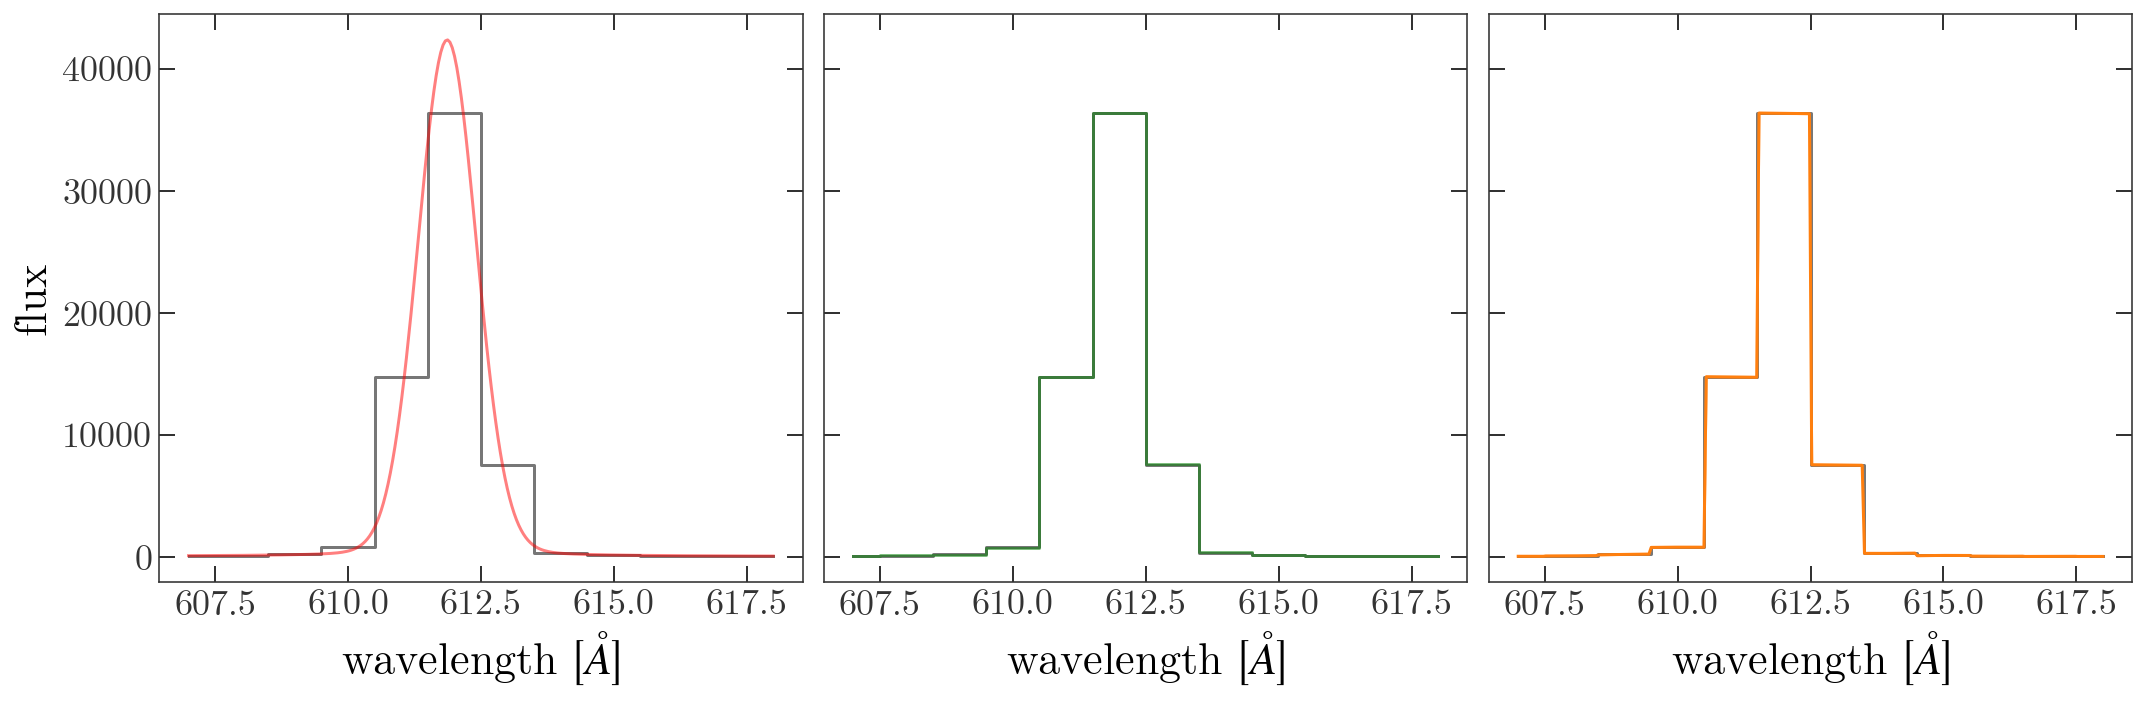

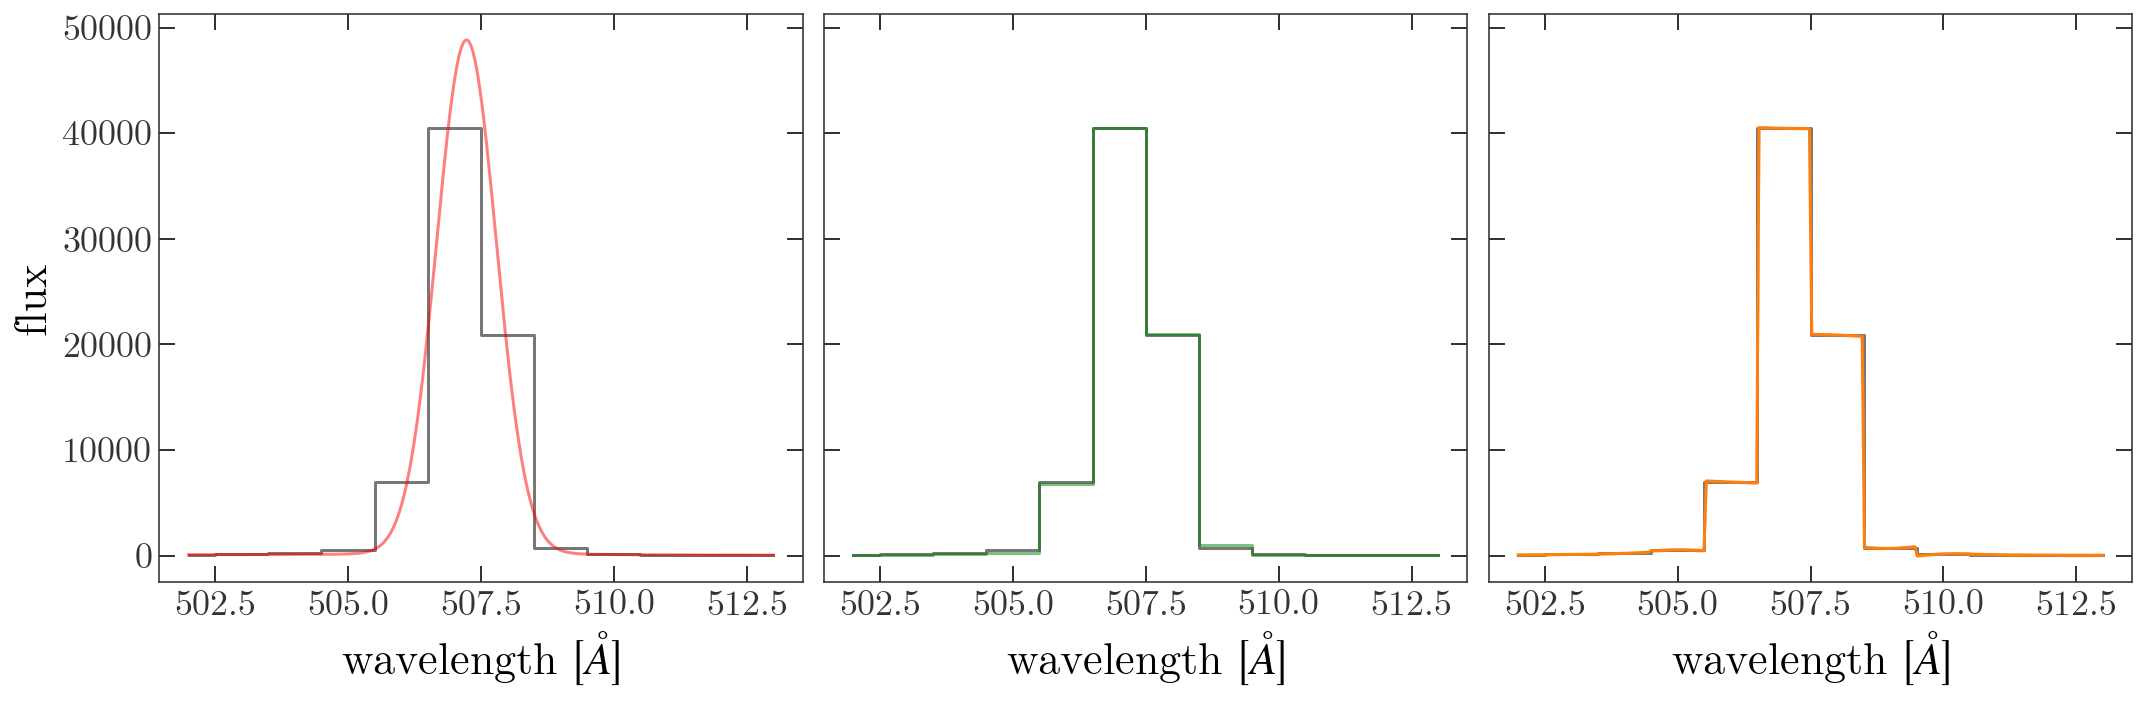

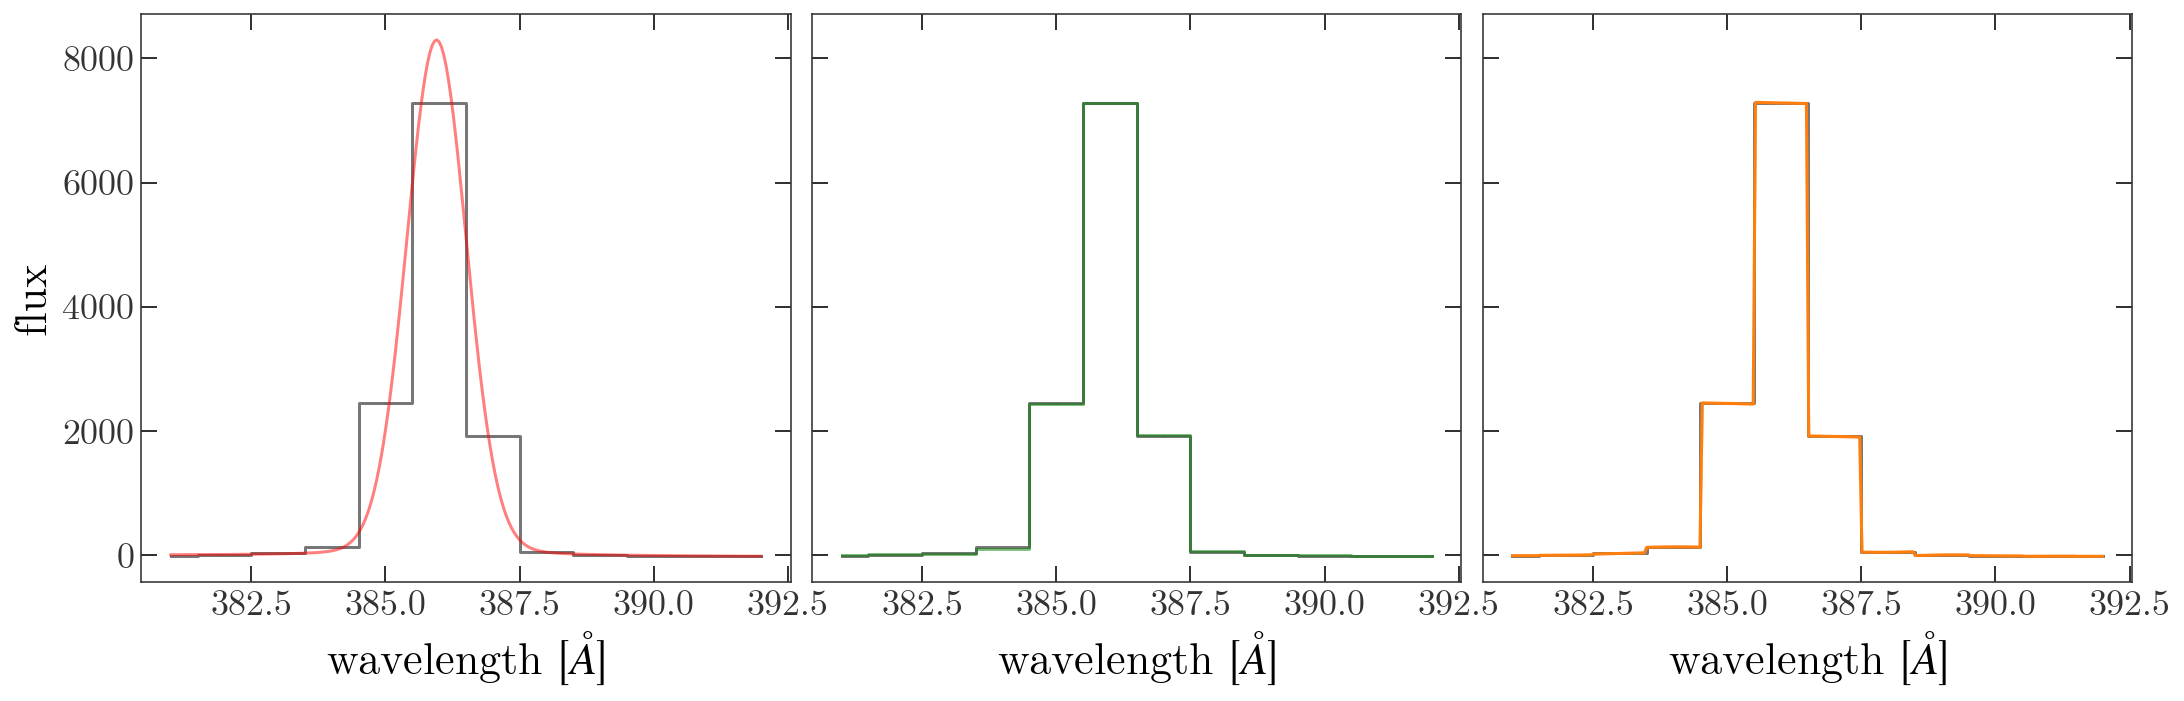

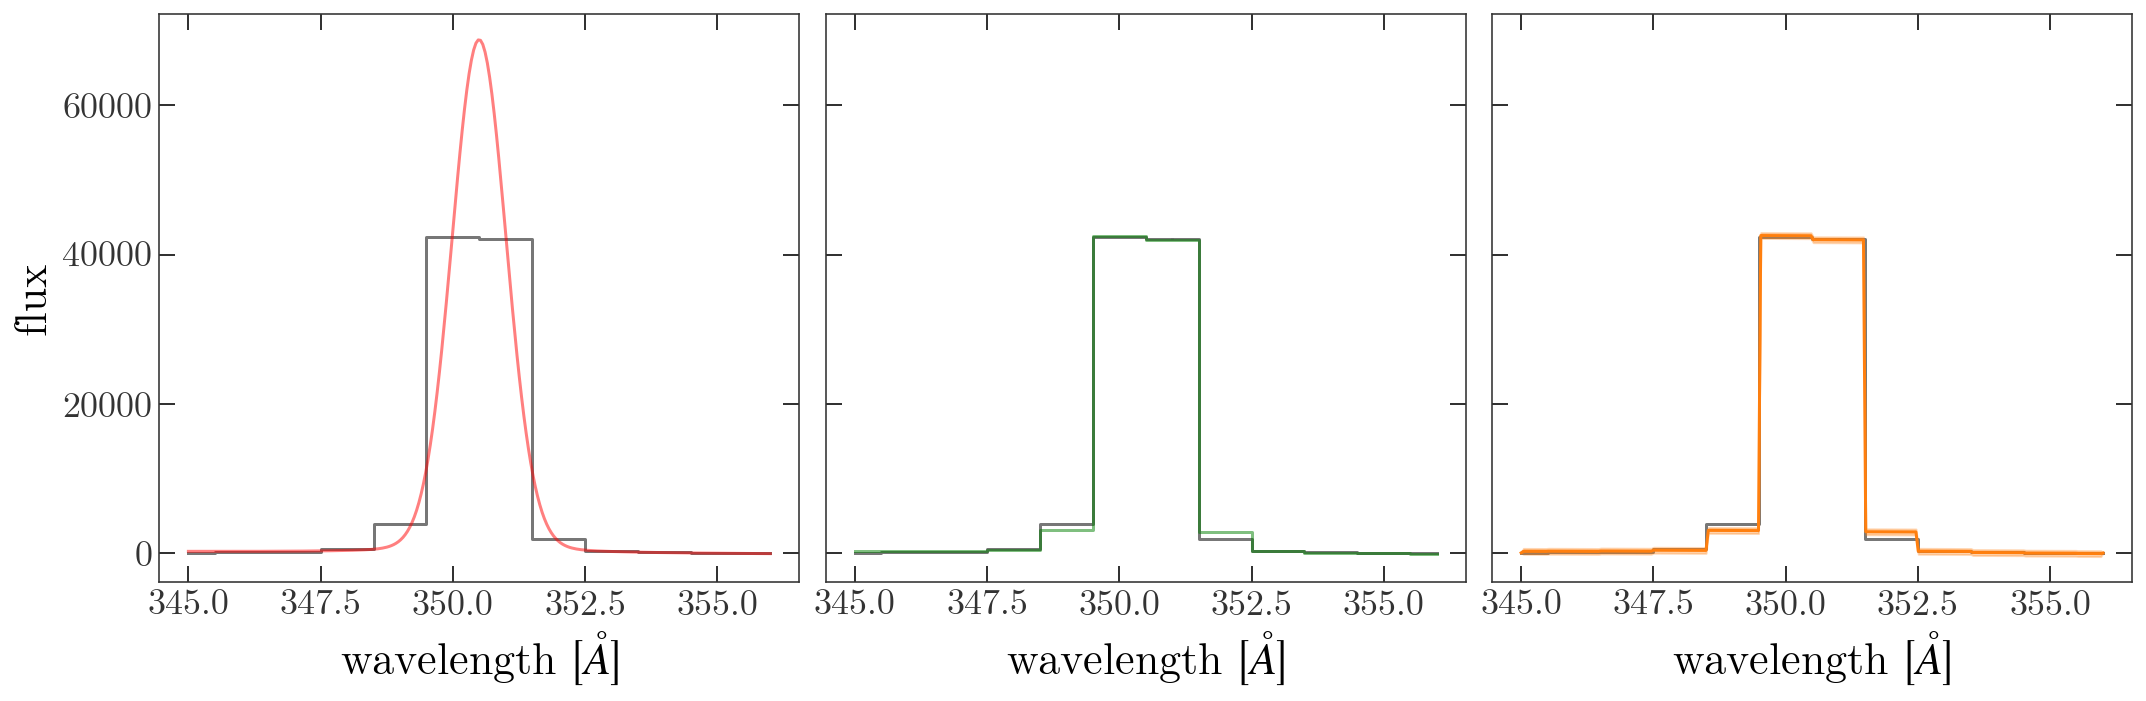

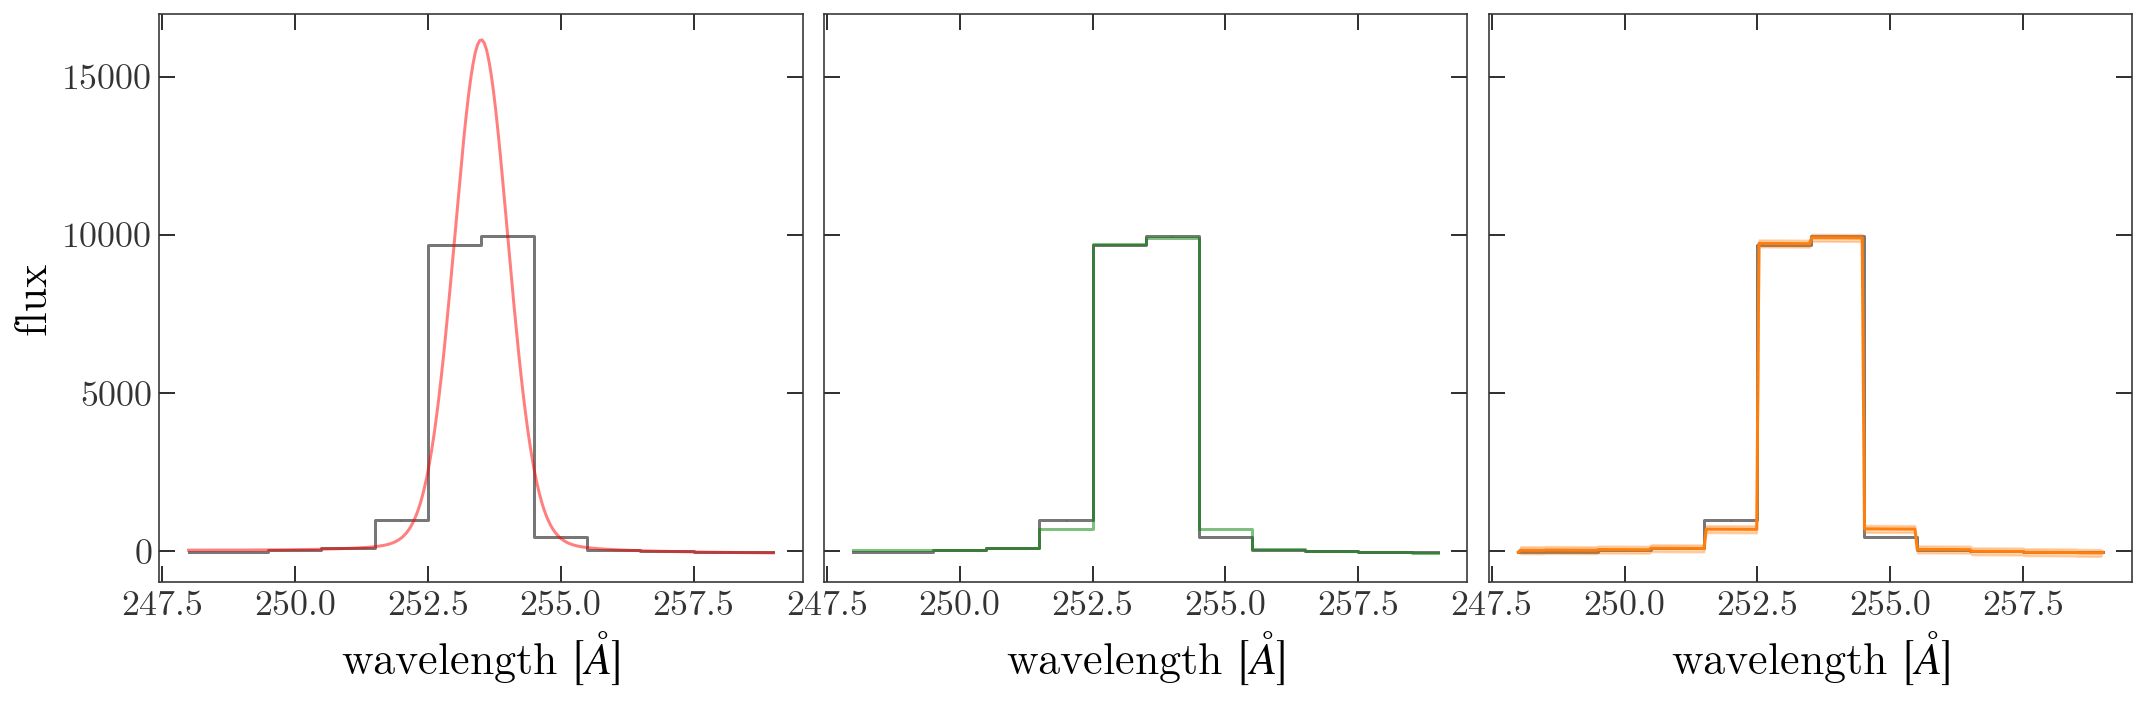

In [11]:
pix_x0s_GP = fit_all_lines_GP(spec['pix'], spec['flux'], spec['ivar'],
                              pix_wav['wavelength'], pix_x0s, half_width=3)

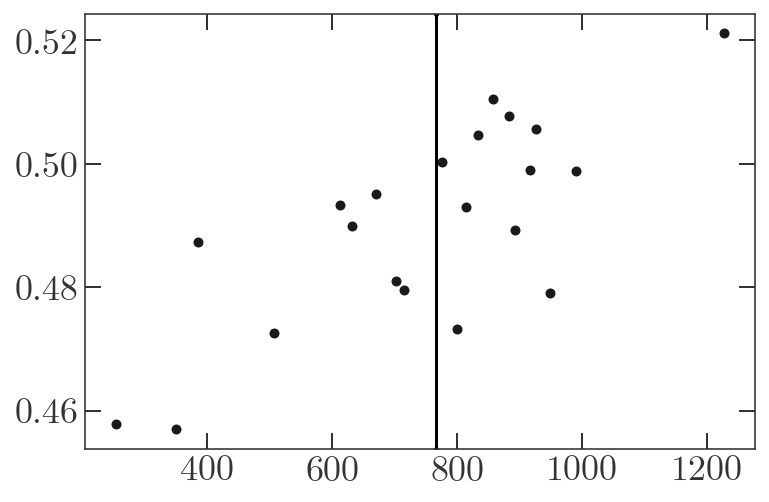

In [12]:
plt.plot(pix_x0s_GP, pix_x0s - pix_x0s_GP, linestyle='none', marker='o')
# plt.ylim(-0.5, 1.5)
plt.axvline(766.5)

(-0.5, 1.5)

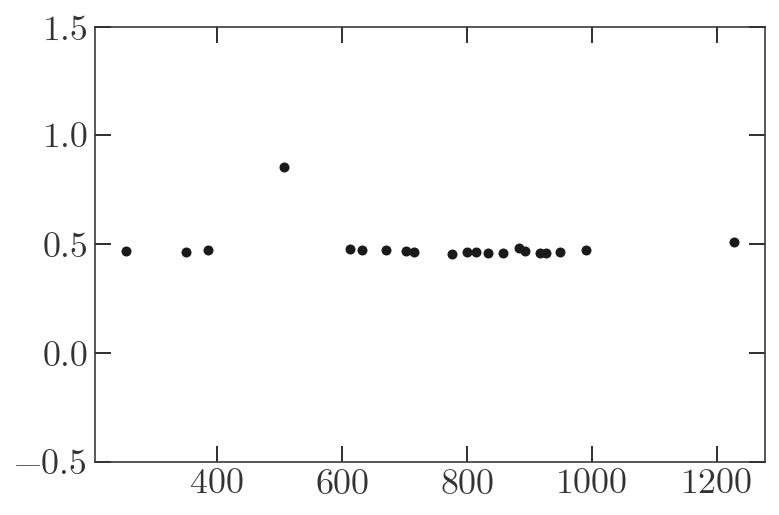

In [13]:
plt.plot(pix_wav['pixel'], pix_x0s - pix_wav['pixel'], linestyle='none', marker='o')
plt.ylim(-0.5, 1.5)

(-0.5, 1.5)

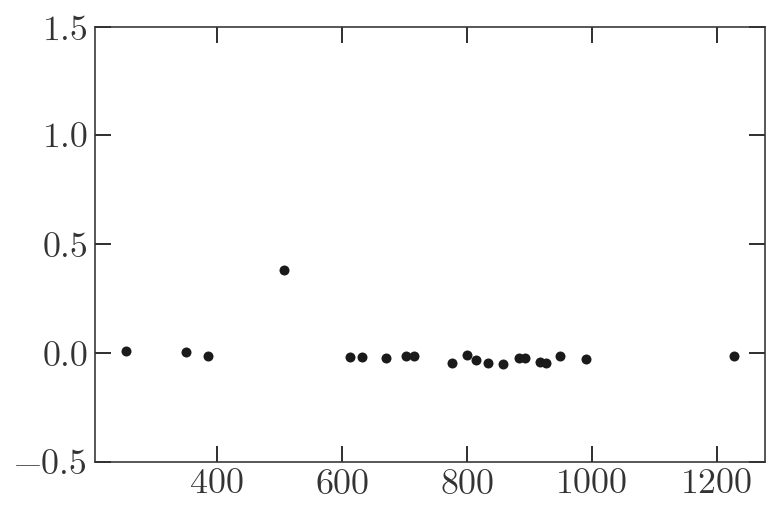

In [14]:
plt.plot(pix_wav['pixel'], pix_x0s_GP - pix_wav['pixel'], linestyle='none', marker='o')
plt.ylim(-0.5, 1.5)

(-0.5, 1.5)

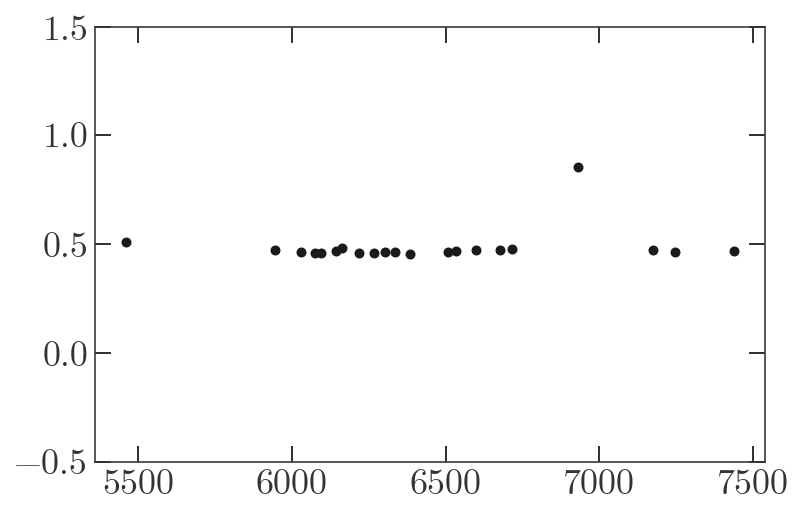

In [15]:
plt.plot(pix_wav['wavelength'], pix_x0s - pix_wav['pixel'], linestyle='none', marker='o')
plt.ylim(-0.5, 1.5)

# plt.xlim(6500, 7000)

(-0.5, 1.5)

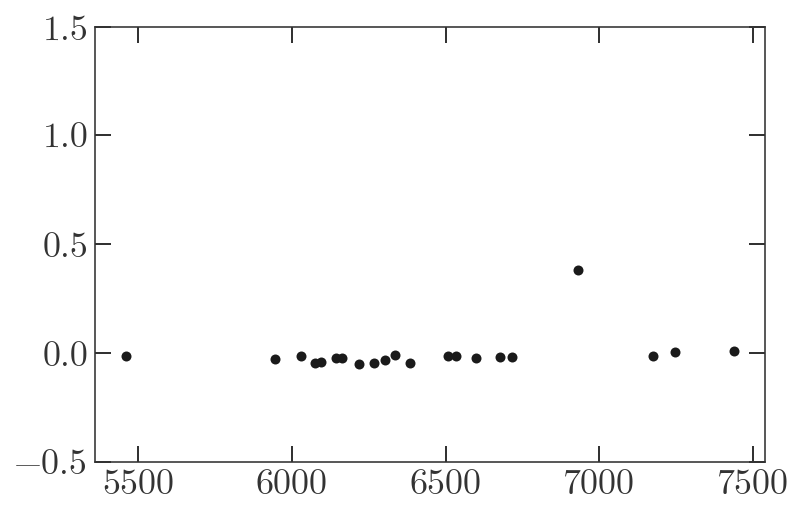

In [16]:
plt.plot(pix_wav['wavelength'], pix_x0s_GP - pix_wav['pixel'], linestyle='none', marker='o')
plt.ylim(-0.5, 1.5)

# plt.xlim(6500, 7000)

In [17]:
pix_x0s = pix_x0s_GP

In [18]:
# --------------------------------------------------------------------------
# fit a gaussian process to determine the pixel-to-wavelength transformation
#
n_bg_coef = 2 # linear
idx = np.argsort(pix_x0s)
med_x = np.median(pix_x0s[idx])
x = pix_x0s[idx] - med_x
y = pix_wav['wavelength'][idx]

model = GPModel(x=x, y=y, n_bg_coef=n_bg_coef, x_shift=med_x)

# Fit for the maximum likelihood parameters
bounds = model.gp.get_parameter_bounds()
init_params = model.gp.get_parameter_vector()
soln = minimize(model, init_params, method="L-BFGS-B",
                bounds=bounds)
model.gp.set_parameter_vector(soln.x)
soln.success

True

HIP 41544: -87 km/s

I get: HIP41544 [1d_n3.0083]: x0=6560.923 Angstrom σ=0.049 Angstrom rv=-106.113 km / s [__main__]

---

HIP24037: 64.30 km/s

HIP24037 [1d_n4.0033]: x0=6566.551 Angstrom σ=0.072 Angstrom rv=68.391 km / s [__main__]

---

HIP22336: 77.24 km/s

HIP22336 [1d_n4.0032]: x0=6567.005 Angstrom σ=0.078 Angstrom rv=166.098 km / s

HIP81461 1.211949


(30000.0, 400000.0)

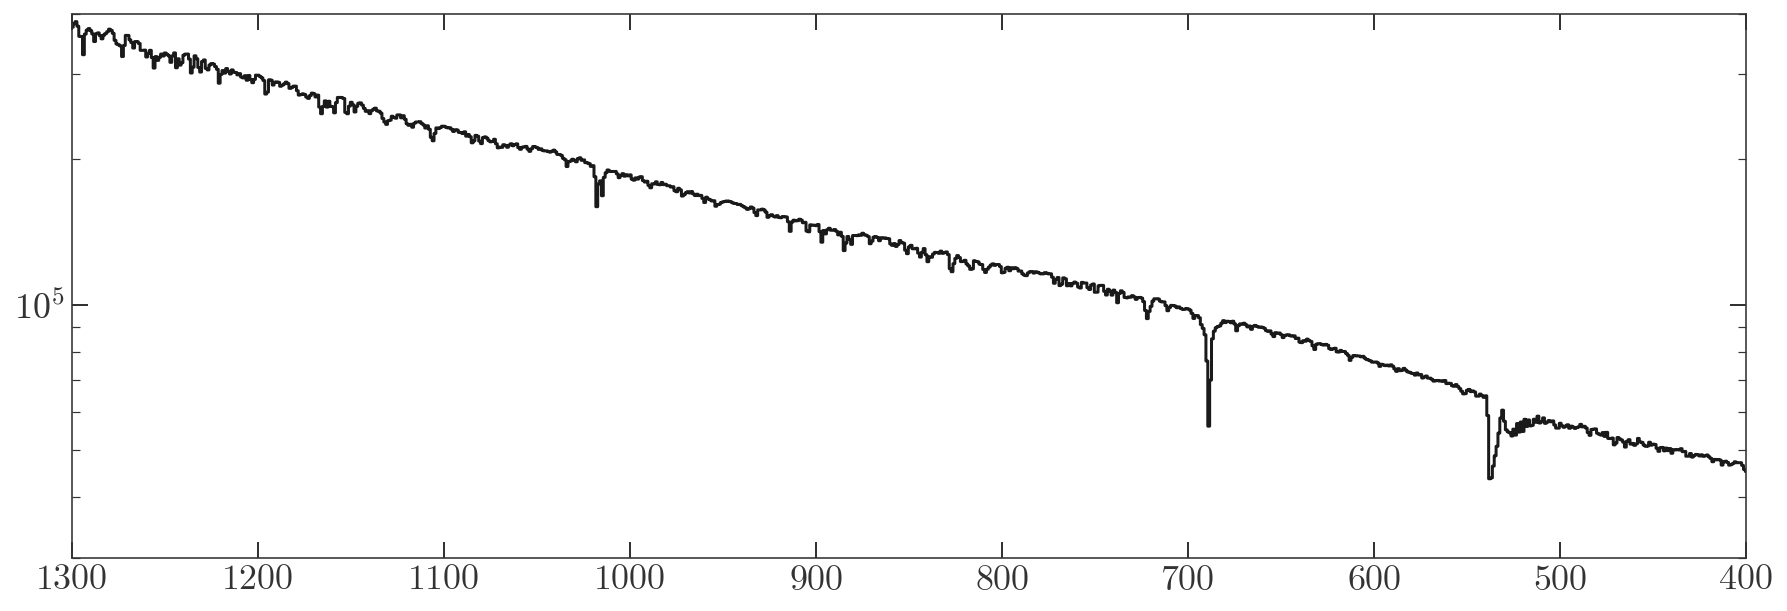

In [134]:
# extract just the middle part of the CCD (we only really care about Halpha)
# hdulist = fits.open(path.join(ifc.location, obj_files[0]))

# file_path = path.join(ifc.location, '1d_n3.0083.fit')
# file_path = path.join(ifc.location, '1d_n4.0033.fit')
# file_path = path.join(ifc.location, '1d_n4.0032.fit')
file_path = path.join(ifc.location, '1d_n4.0209.fit')

hdulist = fits.open(file_path)
tbl = Table(hdulist[1].data)
hdr = hdulist[0].header
print(hdr['OBJECT'], hdr['AIRMASS'])

plt.figure(figsize=(15,5))
plt.plot(tbl['pix'], tbl['source_flux'], marker='', drawstyle='steps-mid')
plt.xlim(1300, 400)
plt.yscale('log')
plt.ylim(3E4, 4E5)

In [135]:
std_tol = 100 * u.angstrom

# compute wavelength array for the pixels
wavelength, var = model.gp.predict(model.y, tbl['pix']-model.x_shift,
                                   return_var=True)
bad_idx = np.sqrt(var) > std_tol.to(u.angstrom).value
wavelength[bad_idx] = np.nan

tbl['wavelength'] = wavelength

In [136]:
lines = []
lines += [5889.951, 5895.924] # Na D
lines += [6562.8] # Halpha
# lines += [6312.1] # [SIII]
# lines += [6716.47, 6730.85] # [SII]
# lines += [5875.67, 6678.152] # He I

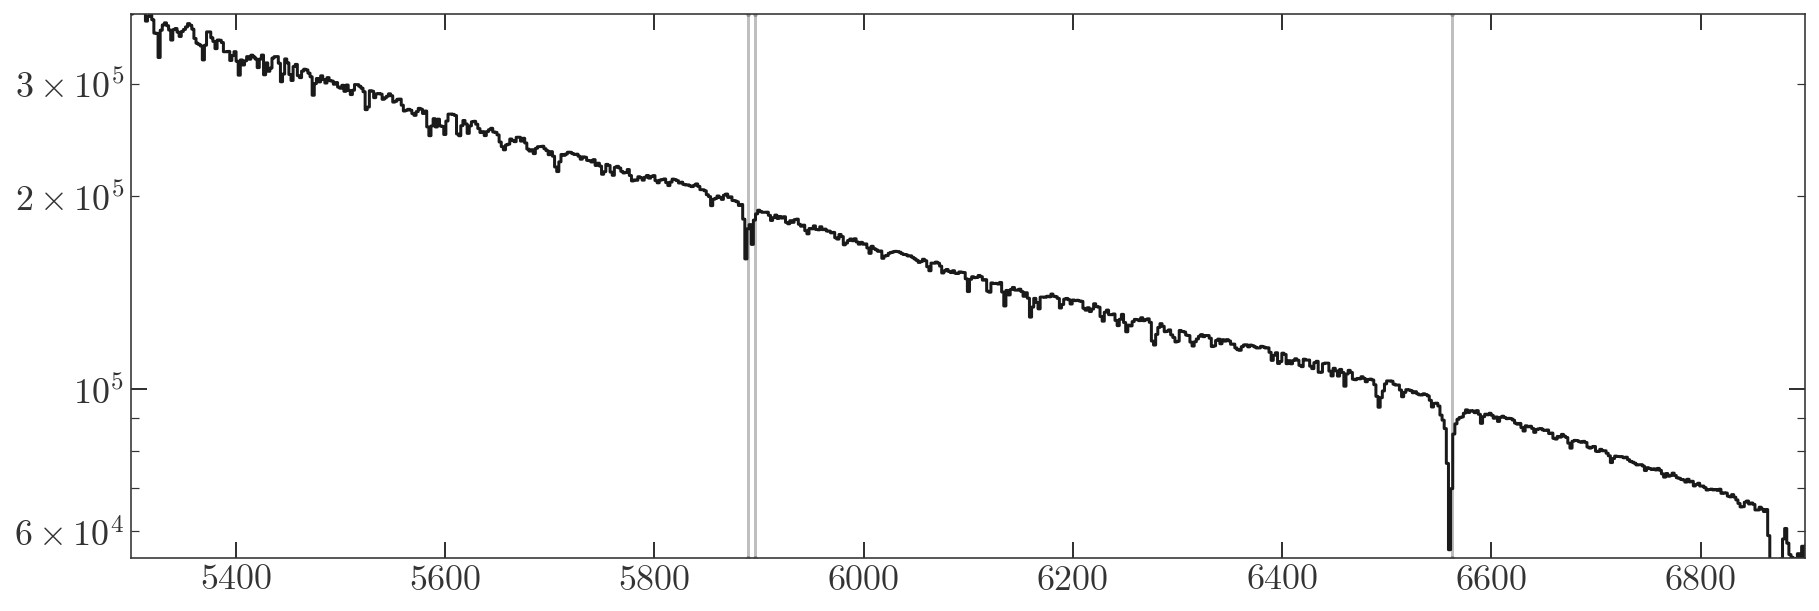

In [137]:
plt.figure(figsize=(15,5))
plt.plot(tbl['wavelength'], tbl['source_flux'], marker='', drawstyle='steps-mid')
plt.xlim(5300, 6900)
# plt.xlim(5800, 6000)
# plt.xlim(6450, 6650)

_i1 = np.nanargmin(np.abs(tbl['wavelength'] - plt.xlim()[1]))
_i2 = np.nanargmin(np.abs(tbl['wavelength'] - plt.xlim()[0]))
plt.ylim(tbl['source_flux'][_i1], tbl['source_flux'][_i2])

for l in lines:
    plt.axvline(l, zorder=-10, alpha=0.25)

plt.yscale('log')

In [138]:
from comoving_rv.longslit.fitting import fit_source_region, fit_sky_region
from comoving_rv.velocity import bary_vel_corr, kitt_peak

True

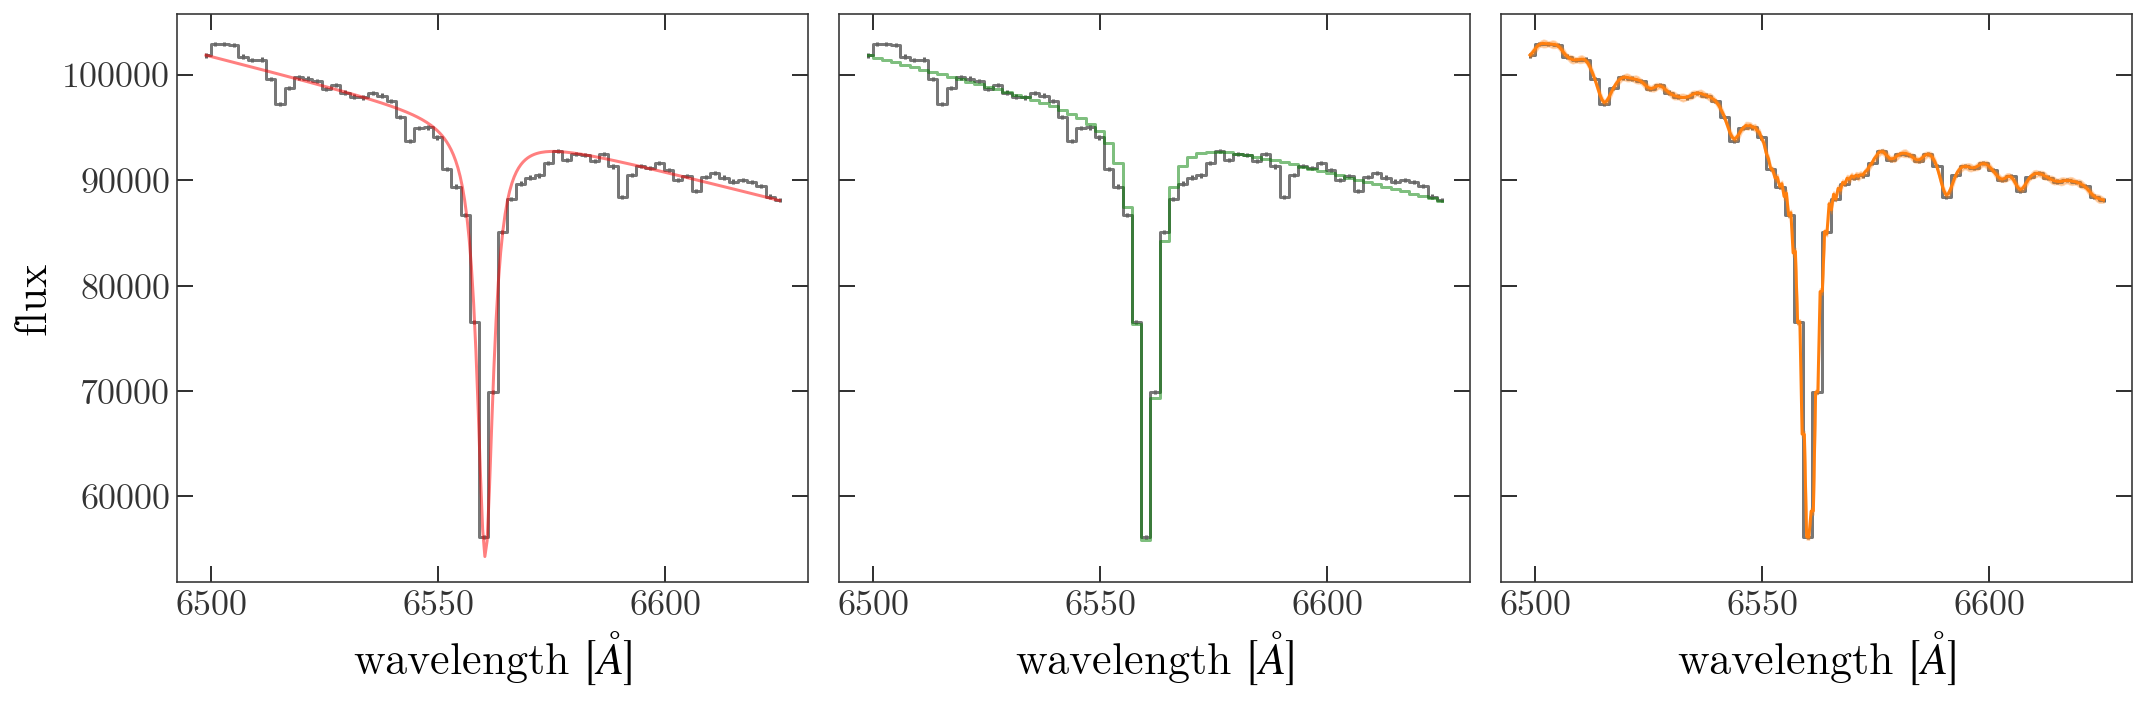

In [139]:
fit_pars, success = fit_source_region(tbl['wavelength'], tbl['source_flux'], tbl['source_ivar'],
                                      center=6562.8, width=64., absorp_emiss=-1., plot=True)
success

In [140]:
fit_pars

OrderedDict([('amp', -277718.14269948588),
             ('x0', 6560.3276361598855),
             ('std_G', 3.6145205242688112e-52),
             ('hwhm_L', 2.155370439872605),
             ('bg_coef', [95231.934286335338, -109.32638139828738])])

In [141]:
raw_rv = ((fit_pars['x0'] - 6562.8) / 6562.8 * c).to(u.km/u.s)

In [142]:
# compute barycenter velocity given coordinates of where the
#   telescope was pointing
print(hdr['OBJECT'])
t = Time(hdr['JD'], format='jd', scale='utc')
sc = coord.SkyCoord(ra=hdr['RA'], dec=hdr['DEC'],
                    unit=(u.hourangle, u.degree))
vbary = bary_vel_corr(t, sc, location=kitt_peak)

HIP81461


In [143]:
raw_rv + vbary

<Quantity -85.64442572941968 km / s>

OrderedDict([('amp', 236.7629003869481), ('x0', 5575.9717376329563), ('std', 1.1676122628788863), ('bg_coef', [48.887134322183549, -0.15294483348146554])])
73476.80140164276 m / s
OrderedDict([('amp', 23.600406753529271), ('x0', 6299.8038399870056), ('std', 1.2757730879939635), ('bg_coef', [14.565783307683436, -0.010764794209240971])])
23799.518196093395 m / s
OrderedDict([('amp', 8.4619482421339622), ('x0', 6363.2531991949854), ('std', 0.57730517388189839), ('bg_coef', [13.351248270651169, -0.037254541151389702])])


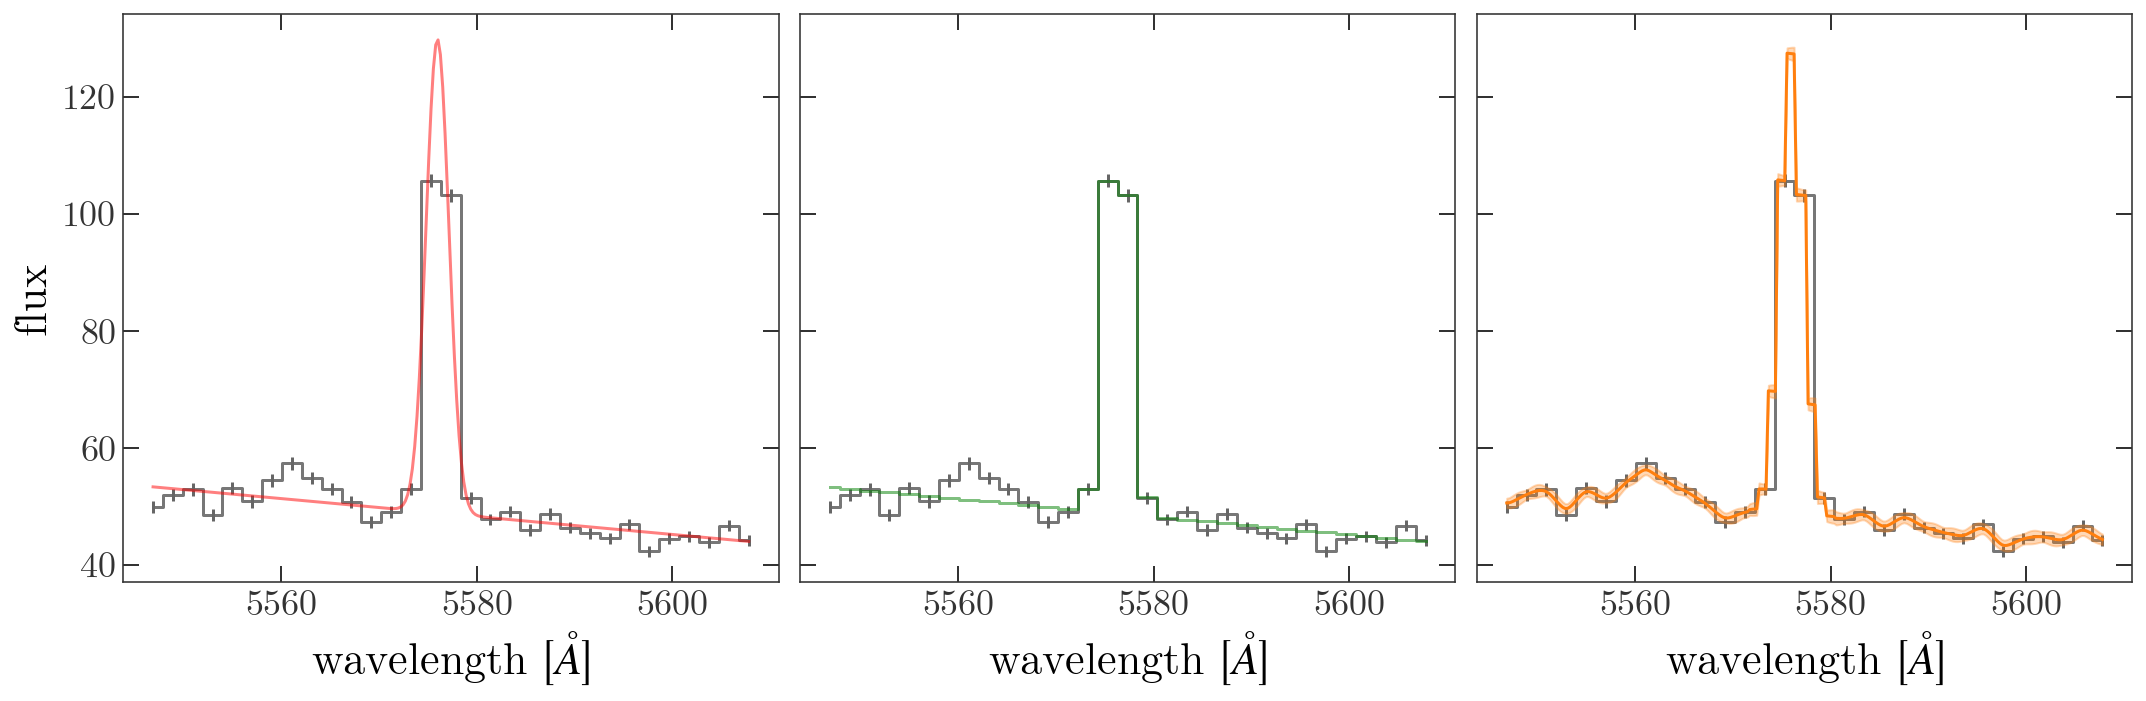

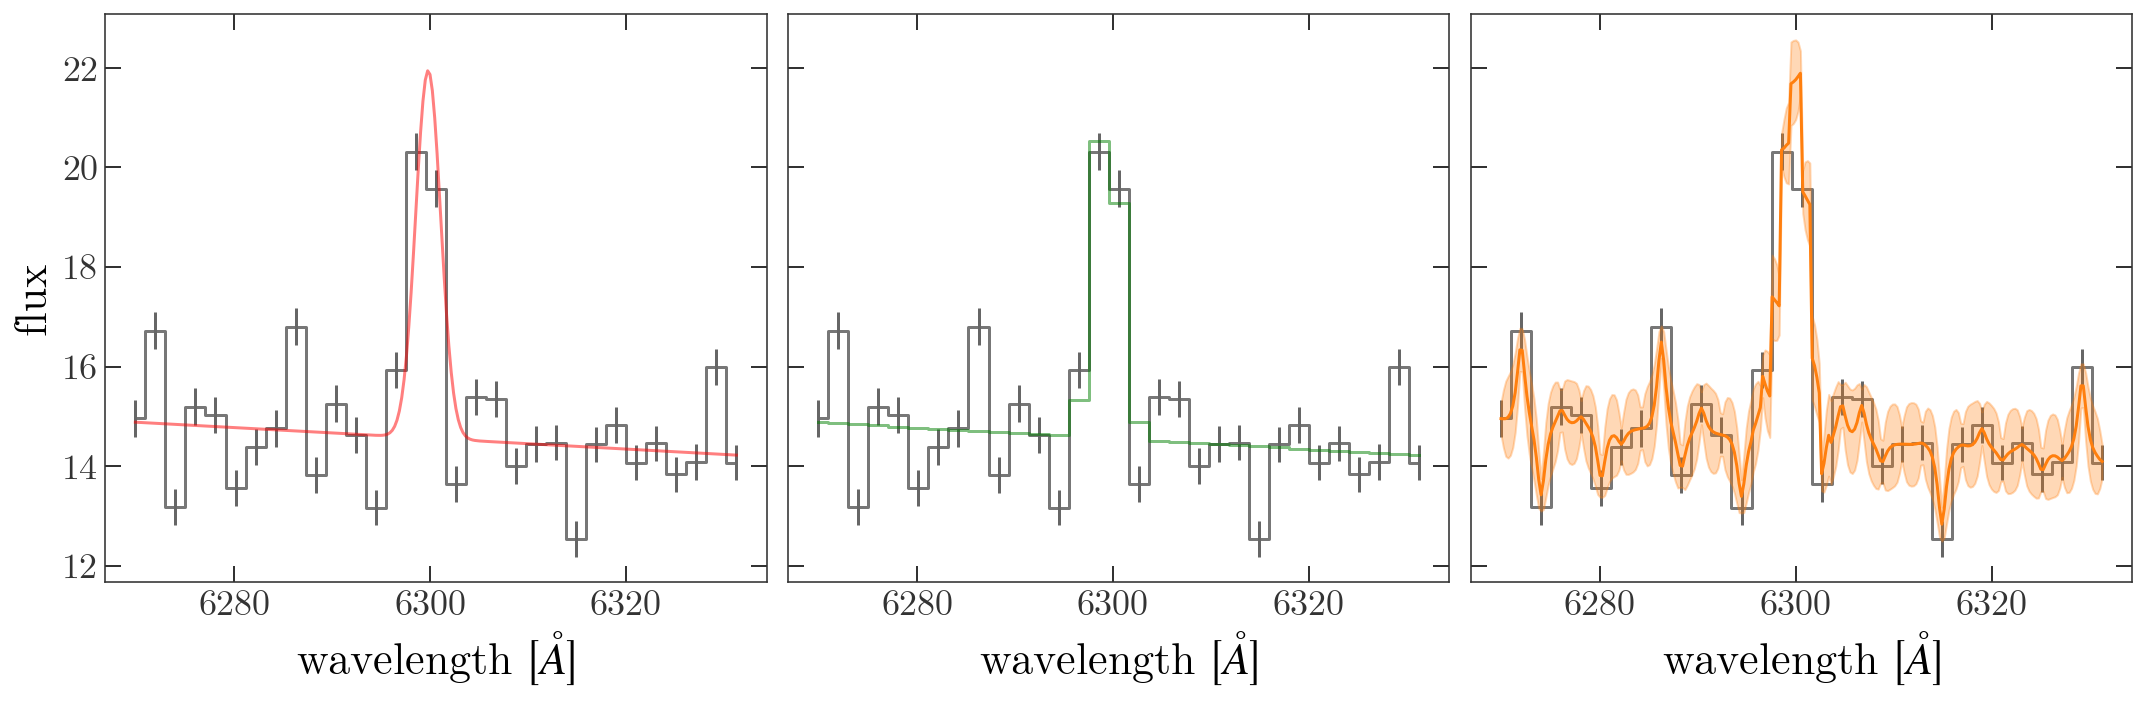

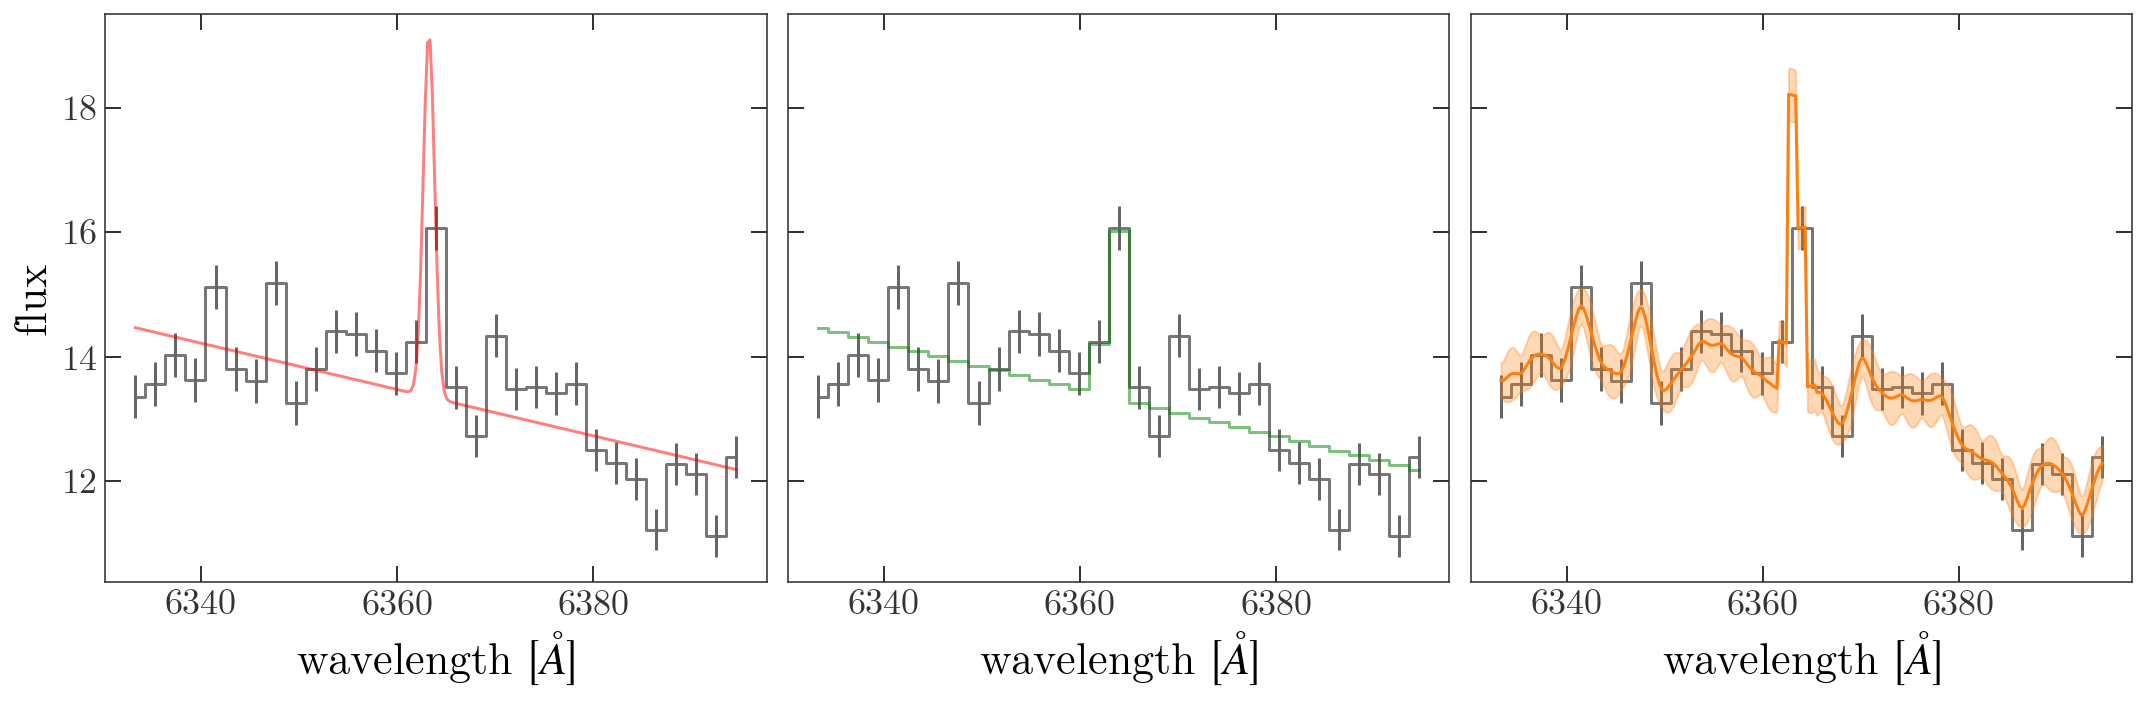

In [144]:
sky_lines = [5577.3387, 6300.304, 6363.776]

dvs = []
for sky_line in sky_lines:
    fit_pars_sky, success = fit_sky_region(tbl['wavelength'], tbl['background_flux'], tbl['background_ivar'],
                                           sky_line, 32., plot=True)
    
    print(fit_pars_sky)
    if success:    
        dv = ((sky_line - fit_pars_sky['x0'])/sky_line) * c
        print(dv)
        dvs.append(dv)
        
    else:
        dvs.append(np.nan * u.km/u.s)
        
weights = np.array([0.55, 1.3, 0.8])
dv = np.nanmean(u.Quantity(dvs) * weights)

In [145]:
# fit_pars_sky = fit_region(tbl['wavelength']*u.angstrom, tbl['background_flux'], tbl['background_ivar'],
#                               6300.*u.angstrom, 32.*u.angstrom, absorp_emiss=1.)

In [146]:
raw_rv + vbary + dv

<Quantity -49.968618516507206 km / s>